In [1]:
# Import packages
import os, sys, glob, re, math, pickle
import phate, scprep, magic, meld
import graphtools as gt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time,random,datetime
import networkx as nx
import scvelo as scv
from sklearn import metrics
from sklearn import model_selection
from scipy import sparse
from scipy.stats import mannwhitneyu, tiecorrect, rankdata
from statsmodels.stats.multitest import multipletests
import scanpy as sc
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import SpectralClustering, OPTICS, cluster_optics_dbscan, AgglomerativeClustering
import bbknn

In [2]:
# Import packages
import os, sys, glob, re, math, pickle
import phate, scprep, magic, meld
import graphtools as gt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time,random,datetime
import networkx as nx
import scvelo as scv
from sklearn import metrics
from sklearn import model_selection
from scipy import sparse
from scipy.stats import mannwhitneyu, tiecorrect, rankdata
from statsmodels.stats.multitest import multipletests
import scanpy as sc
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import SpectralClustering, OPTICS, cluster_optics_dbscan, AgglomerativeClustering
from bbknn import bbknn


%matplotlib inline
%load_ext memory_profiler



In [3]:
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [4]:
# settings
plt.rc('font', size = 8)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=8)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1

In [5]:
# reproducibility
rs = np.random.seed(42)


In [7]:
# fps
dfp = '/home/cl2292/project/SCA1_snRNAseq/Mouse/data/'
pfp = '/home/cl2292/project/SCA1_snRNAseq/Mouse/results/'
sc.settings.figdir = pfp

In [8]:
# Load Data

if True :
    start = time.time()
    backed=None # None if not
    fname='mouse_wt_imputed.h5ad' # for full, can maybe get away with ~300G
    %memit wt = sc.read_h5ad(os.path.join(dfp,fname),backed=backed)
    print('loaded @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to load data'.format(time.time()-start))
    
if True :
    start = time.time()
    backed=None # None if not
    fname='mouse_sca1_imputed.h5ad' # for full, can maybe get away with ~300G
    %memit mut = sc.read_h5ad(os.path.join(dfp,fname),backed=backed)
    print('loaded @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to load data'.format(time.time()-start))    

peak memory: 38723.33 MiB, increment: 38421.64 MiB
loaded @220517.11:21:25
took 36.28-s to load data
peak memory: 74578.57 MiB, increment: 35862.51 MiB
loaded @220517.11:21:59
took 34.49-s to load data


In [8]:
# Load Data

if True :
    start = time.time()
    backed=None # None if not
    fname='211027_mouse.h5ad' # for full, can maybe get away with ~300G
    %memit adata = sc.read_h5ad(os.path.join(dfp,fname),backed=backed)
    print('loaded @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to load data'.format(time.time()-start))
    

peak memory: 10849.89 MiB, increment: 10573.21 MiB
loaded @211110.10:13:49
took 15.45-s to load data


In [21]:
adata

AnnData object with n_obs × n_vars = 318312 × 26374
    obs: 'batch', 'genotype', 'timepoint', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pmito', 'n_genes', 'louvain', 'res_sca1', 'ees_sca1', 'stored_ctype', 'ctype', 'sub1', 'sub2'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'ctype_colors', 'louvain', 'neighbors', 'pca', 'sub1_colors', 'sub2_colors', 'umap'
    obsm: 'X_pca', 'X_phate', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

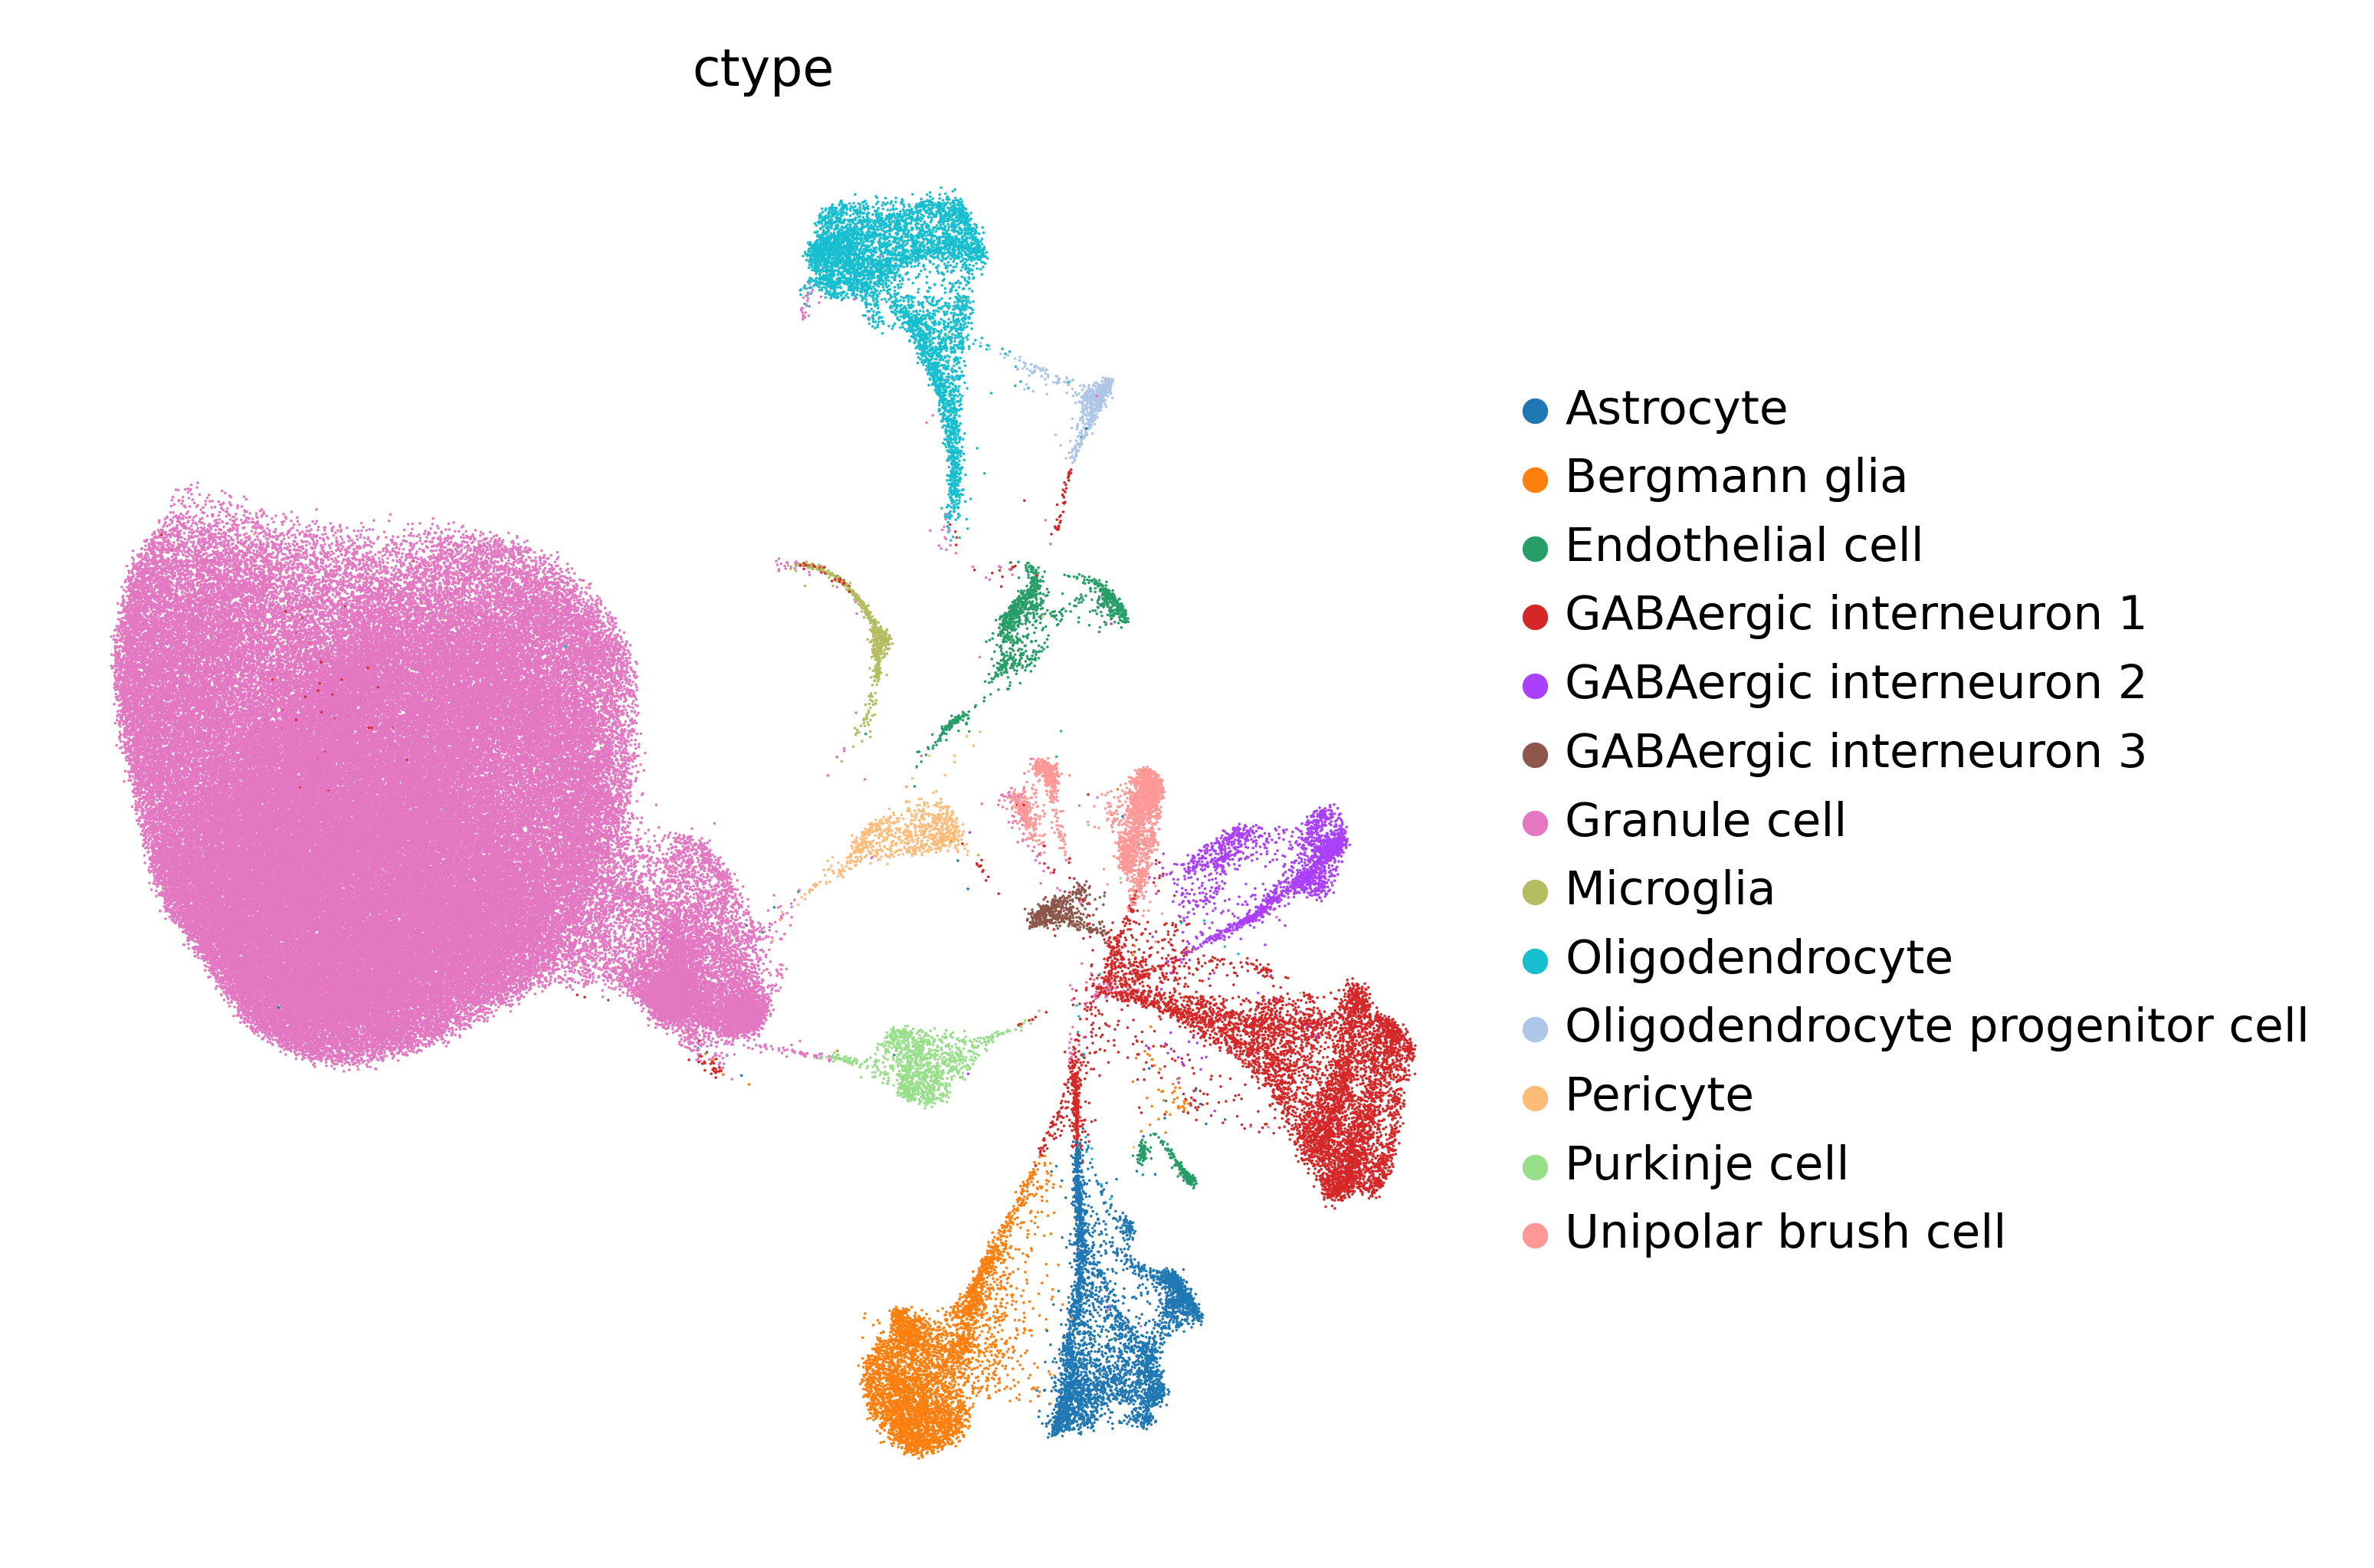

In [9]:
sc.pl.umap(wt, color ='ctype')

In [16]:
markers = ['Aldoc', 'Kctd16', 'Gpr176', 'Drd3', 'Ephb2', 'Tshz2', 
           'Fam19a2', 'Alcam', 'Tox2', '2900055J20Rik', 'Vmn2r30', 
           'Atp2a3','Car8','Calb1','Fam107b']
markers2 = ['Gad1', 'Gad2', 'Ptprk', 'Adgrl3', 'Nxph1', 'Cdh22', 'Lgi2', 'Nrg1','Klhl1','Pax2']
markers3 = ['Aldoc', 'Kctd16', 'Grid2', 'Itpr1', 'Rgs8', 'Prkg1', 'Calb1',
            'Pcdh9', 'Cntnap2', 'Cadm2', 'Nlgn1', 'Nrxn3', 'Homer3', 'Ryr1']

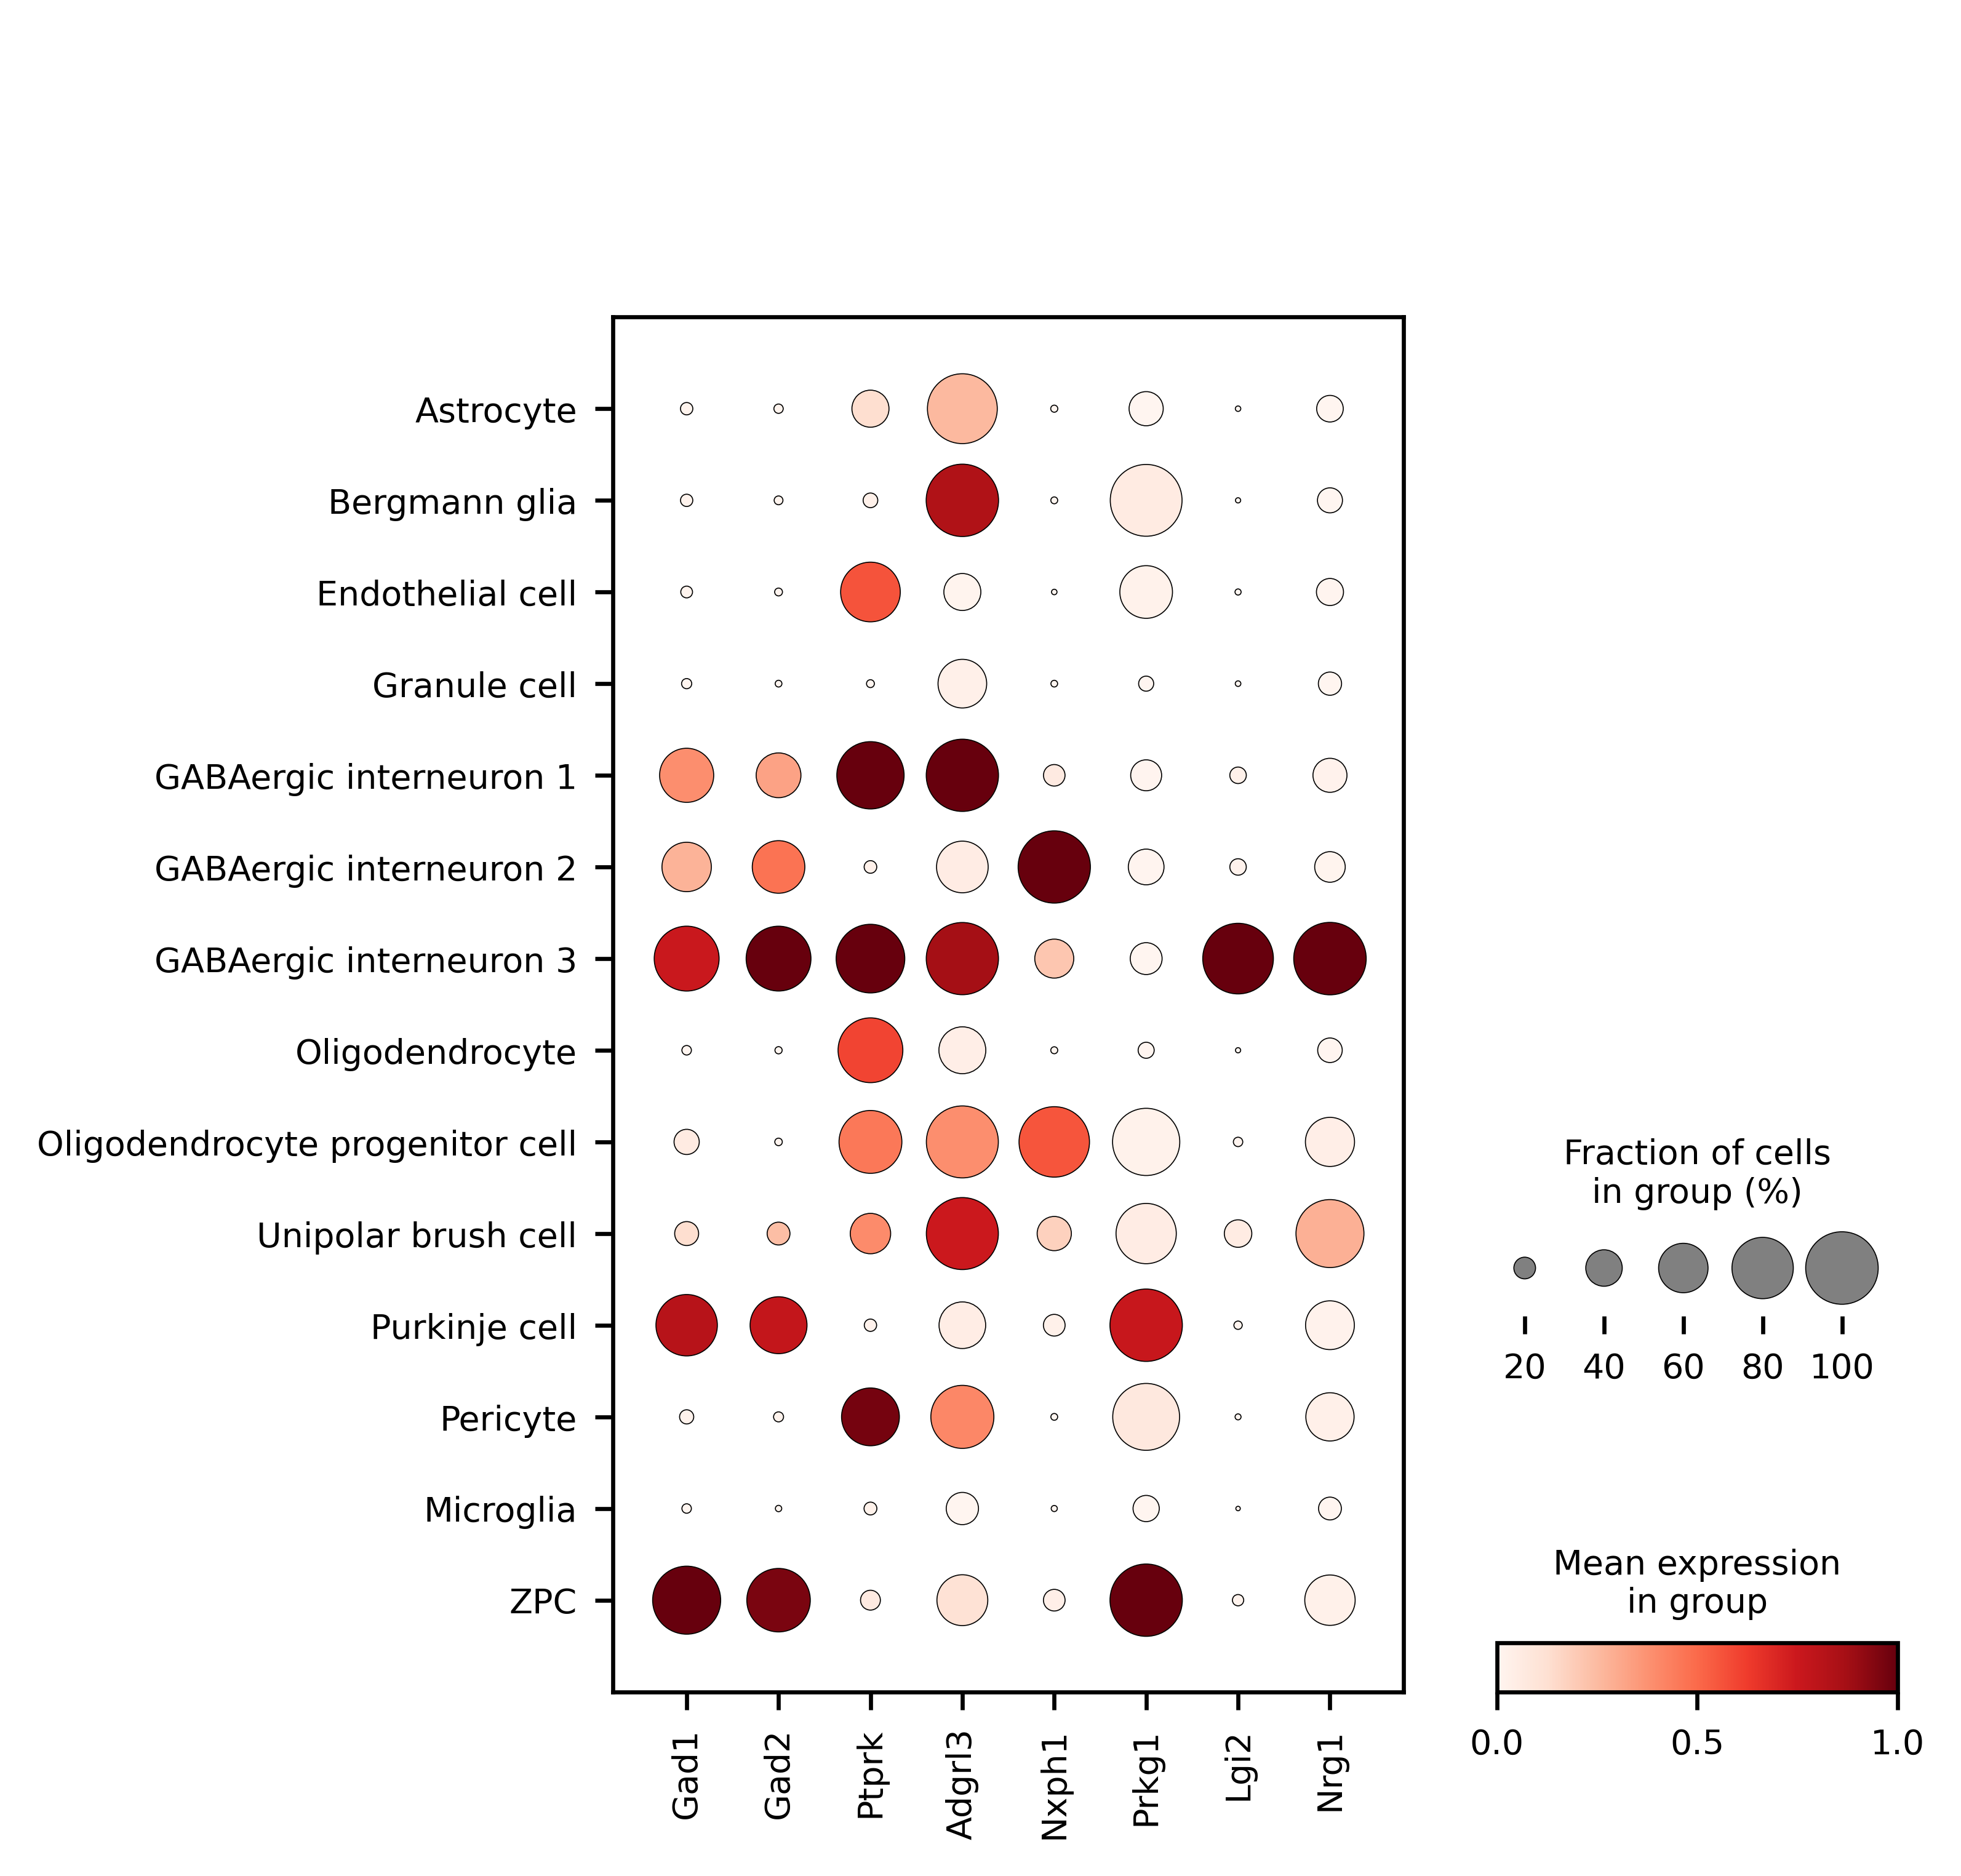

In [66]:
sc.pl.dotplot(adata, markers2, groupby='sub2', standard_scale='var')

In [13]:
sc.tl.louvain(adata, restrict_to=('ctype', ['Purkinje cell']), resolution=1.5, key_added='sub1')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:01)


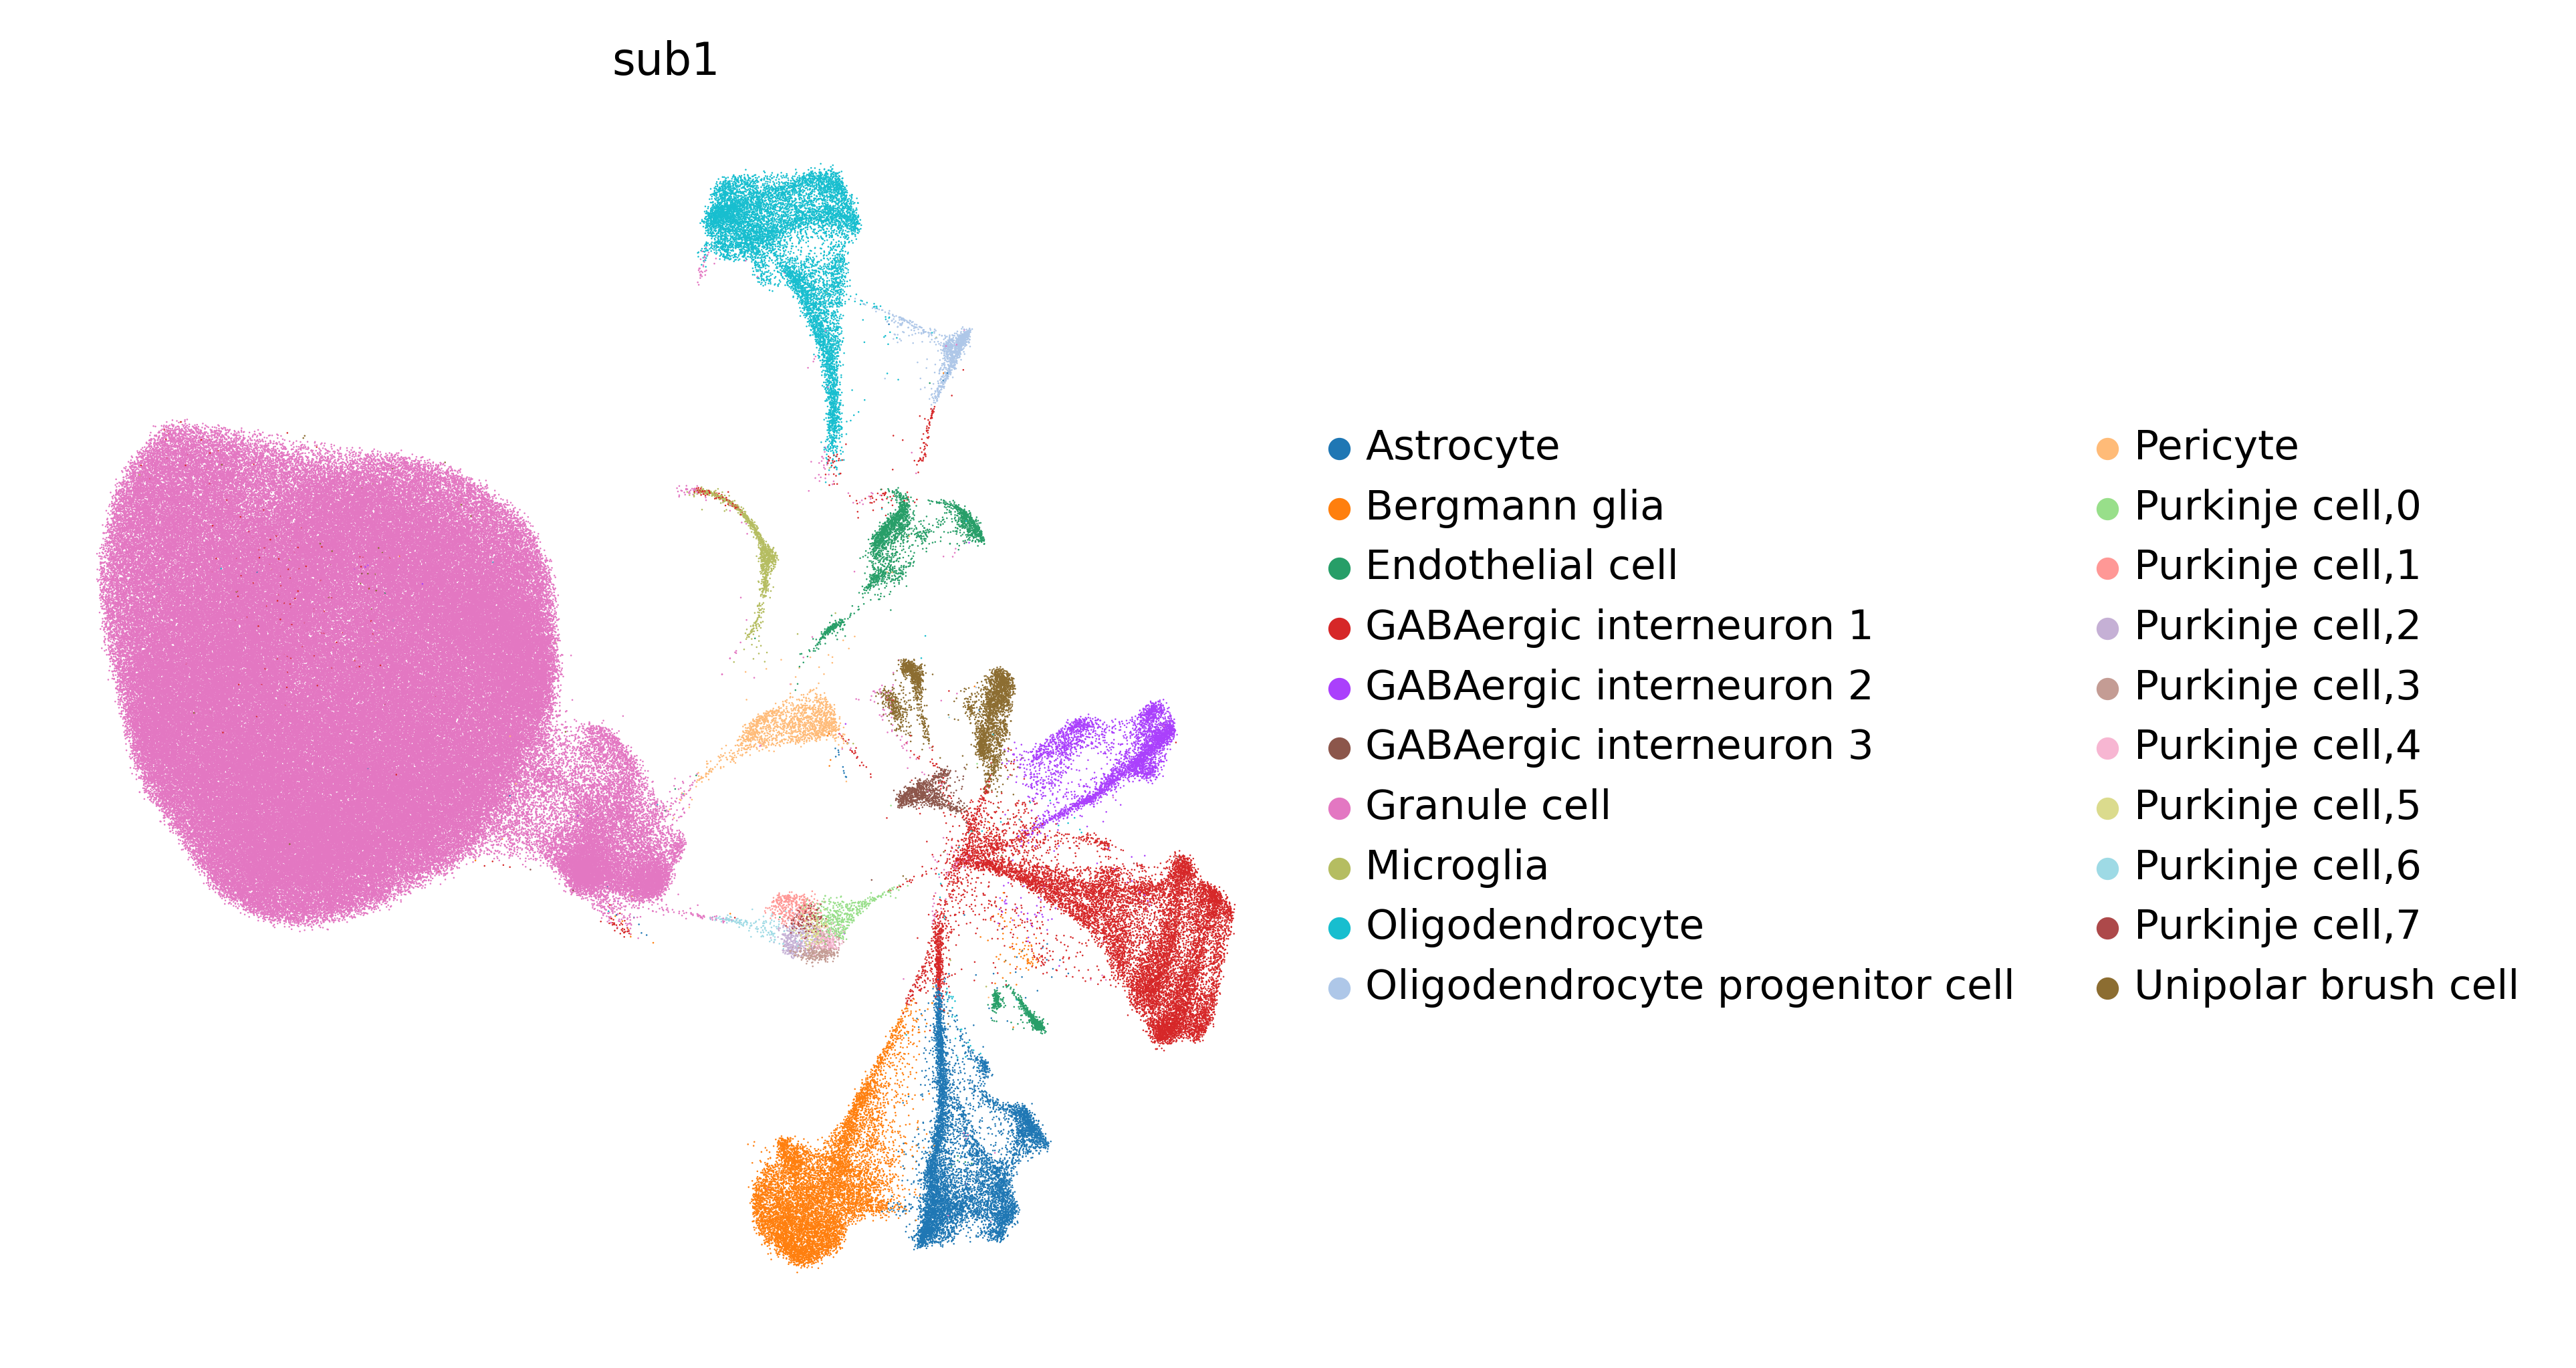

In [14]:
sc.pl.umap(adata, color ='sub1')

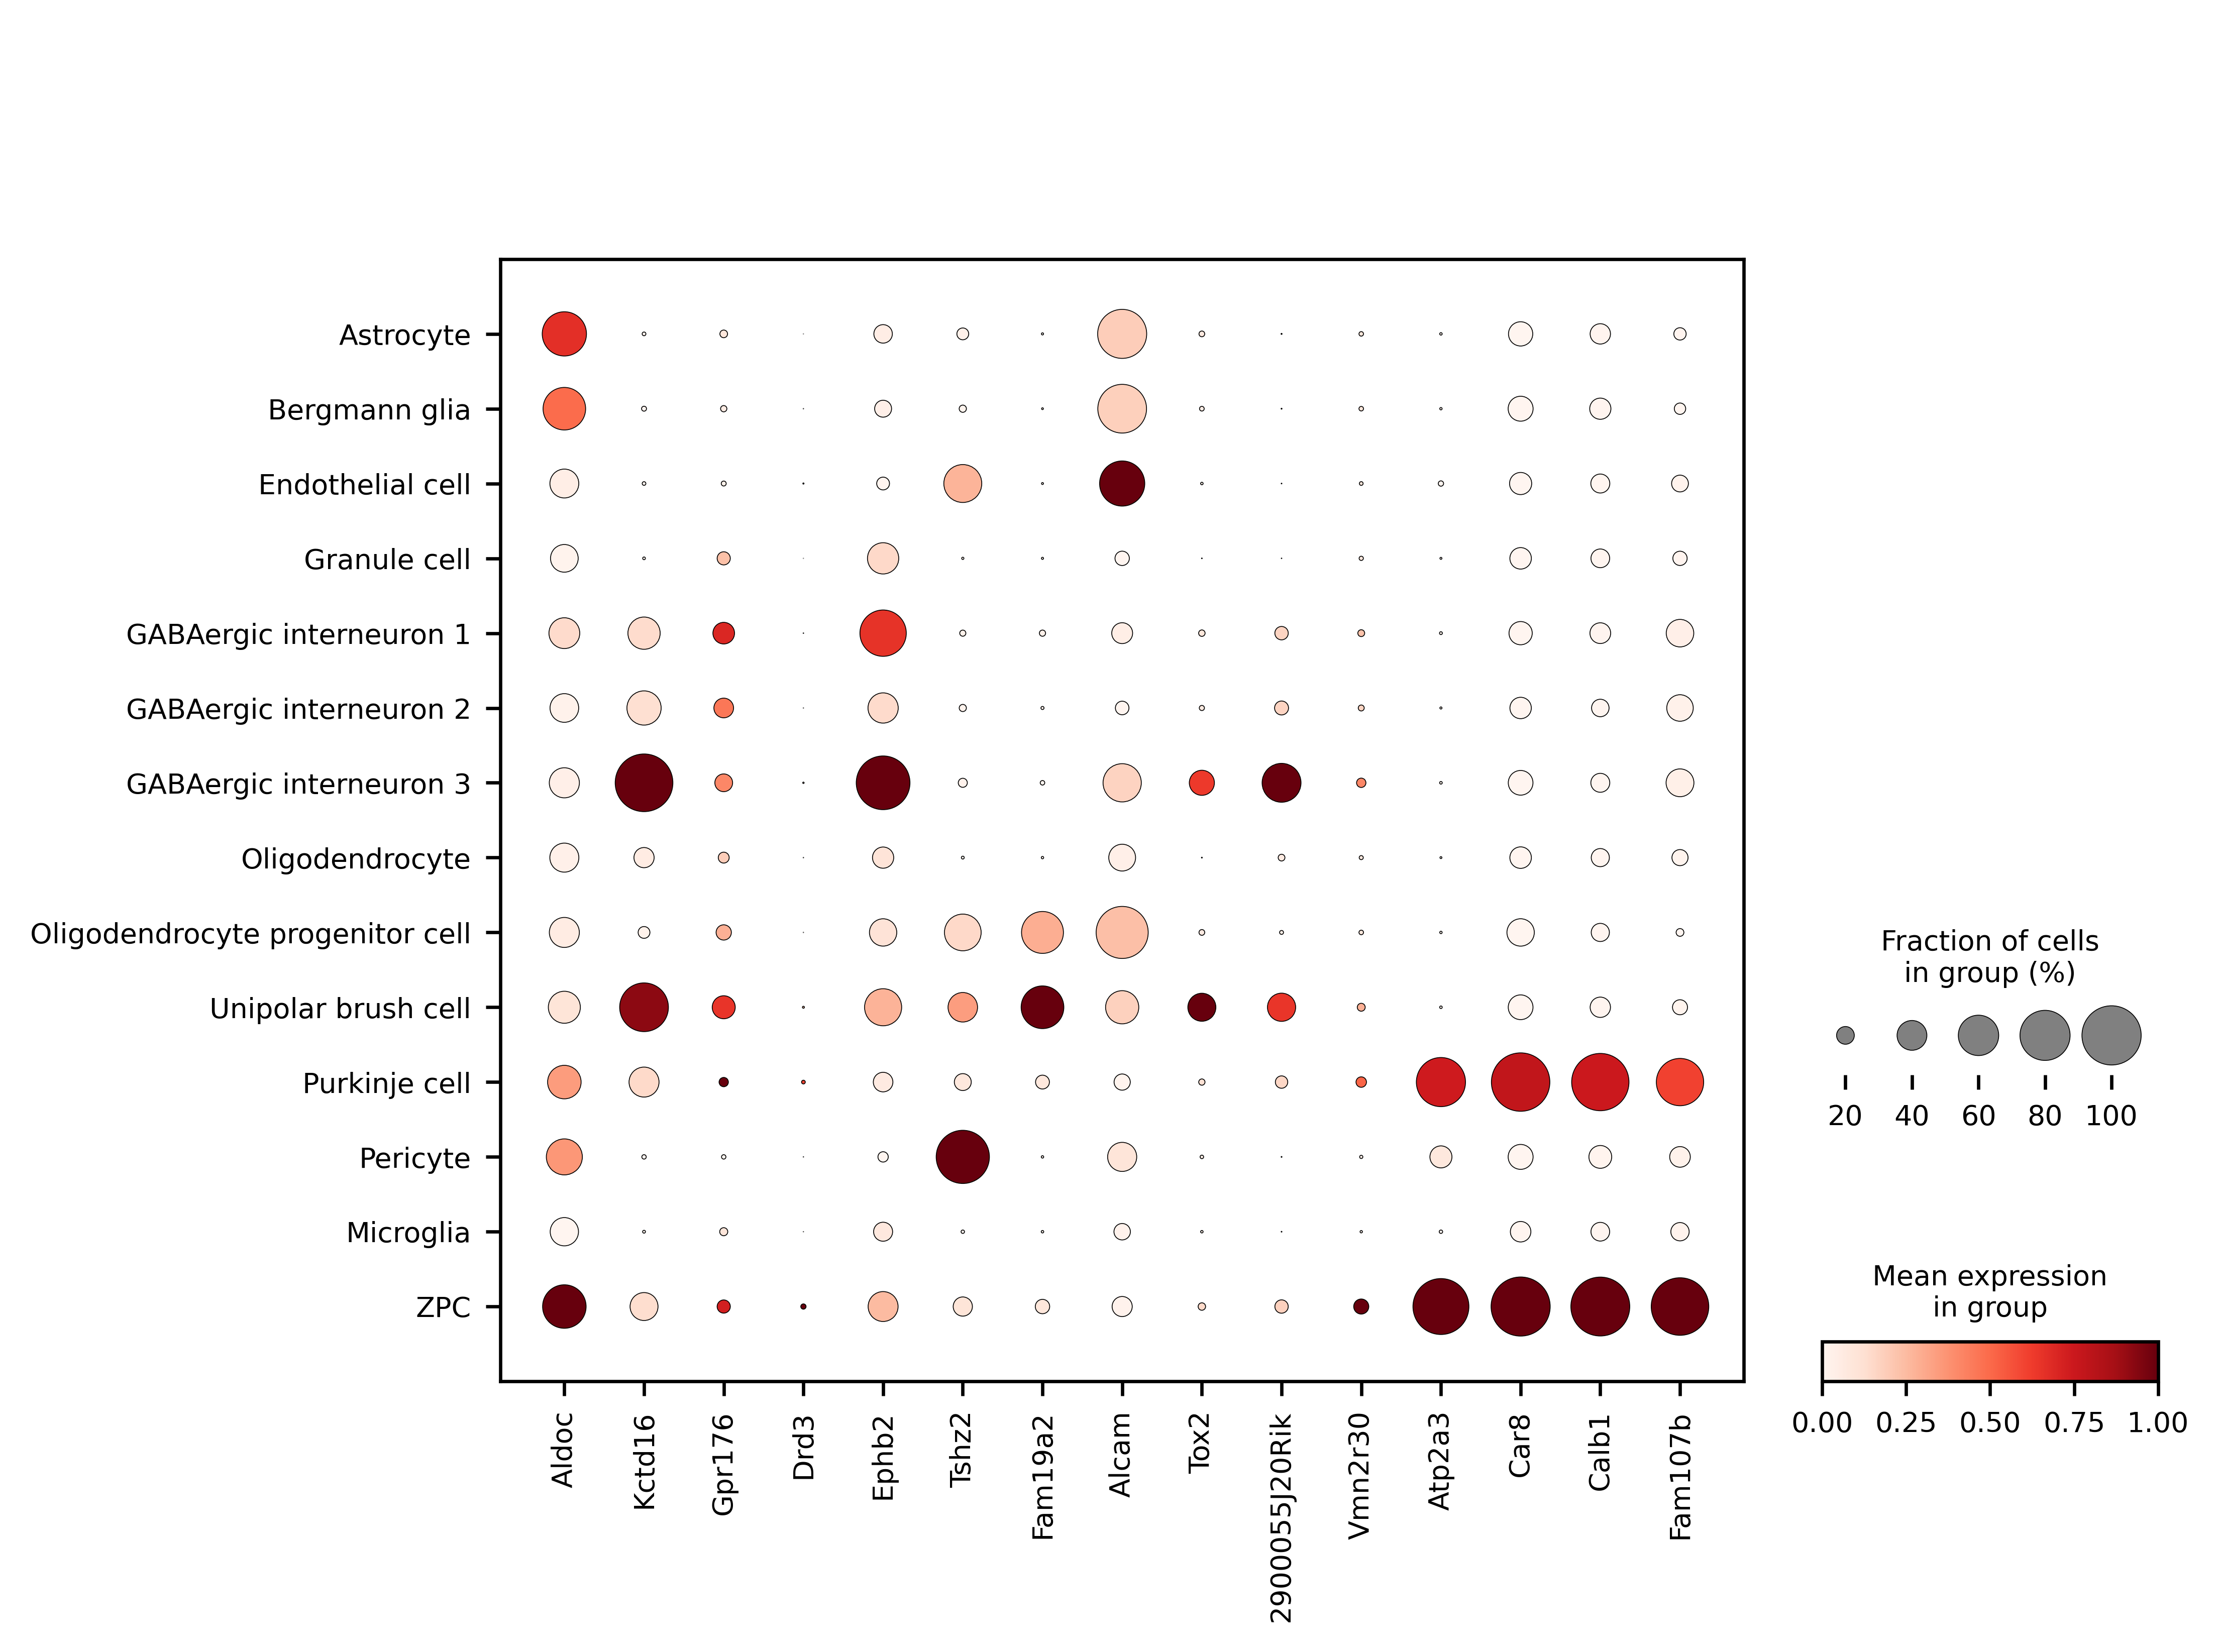

In [18]:
sc.pl.dotplot(adata, markers, groupby='sub2', standard_scale='var')

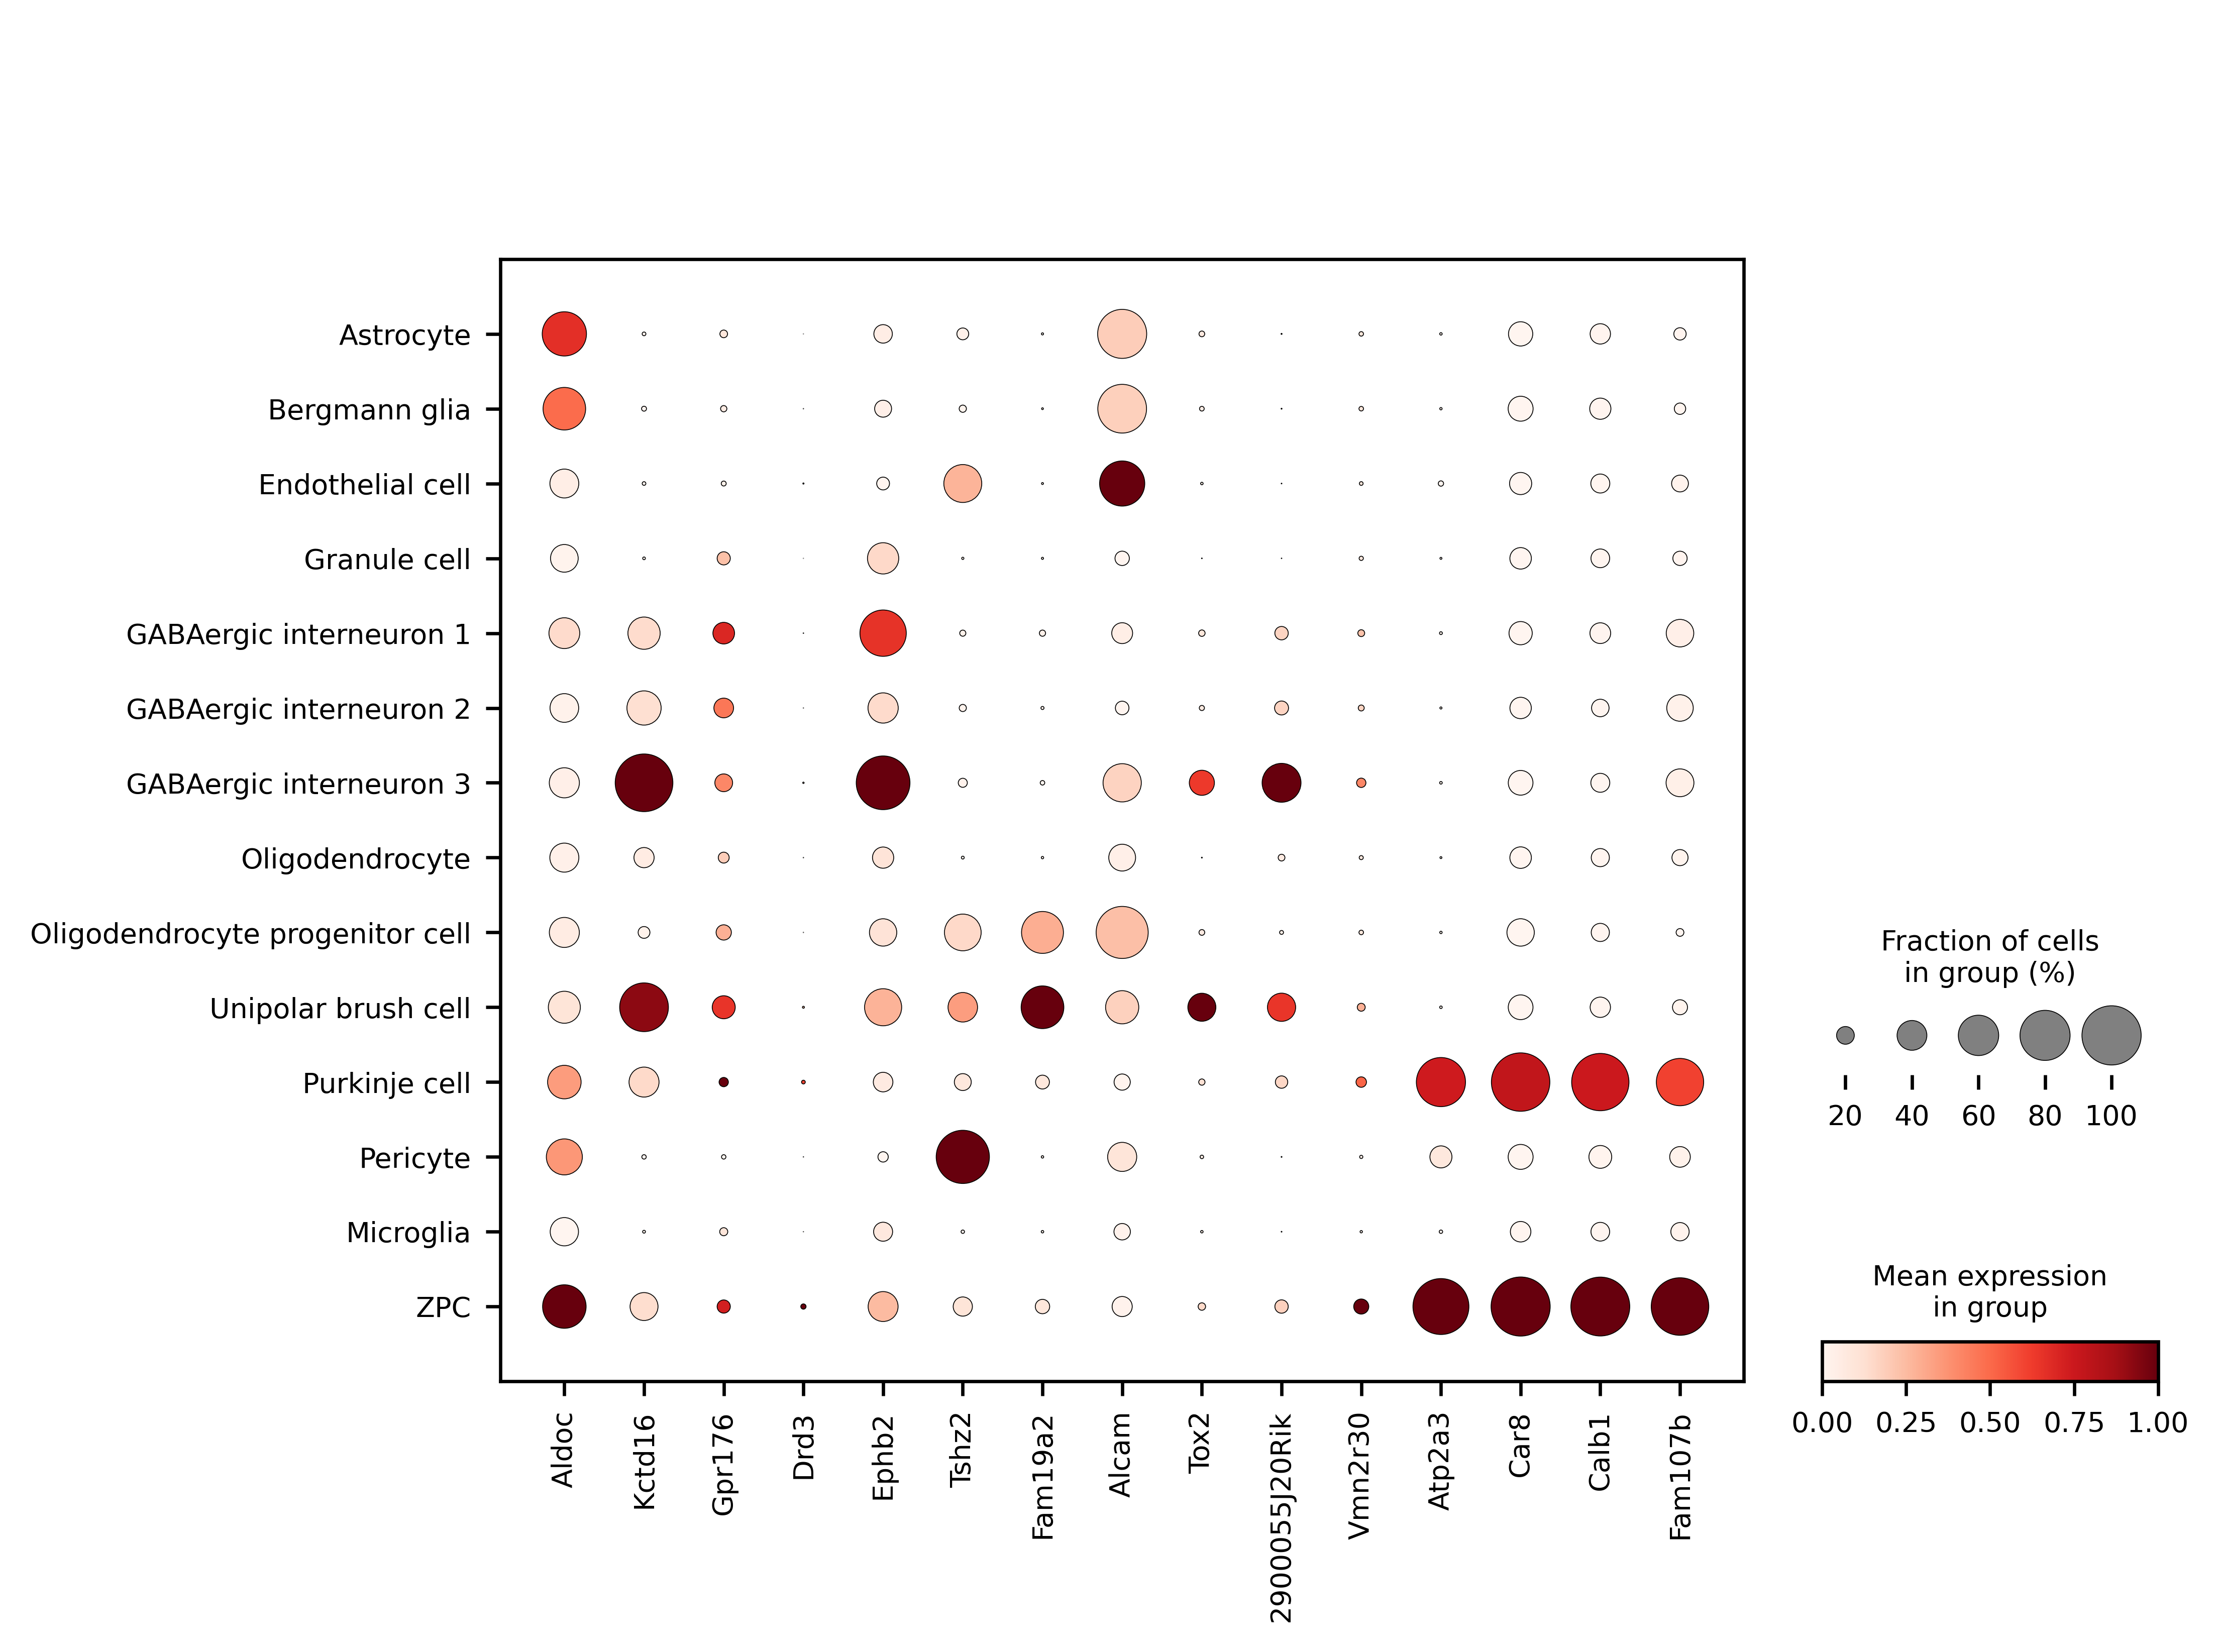

In [55]:
sc.pl.dotplot(adata, markers, groupby='sub2', standard_scale='var')

In [12]:
bdata = adata[(adata.obs['sub2'] == 'Purkinje cell')|(adata.obs['sub2'] == 'ZPC'), :]
cdata = adata[(adata.obs['sub2'] == 'GABAergic interneuron 1')|(adata.obs['sub2'] == 'GABAergic interneuron 2')|(adata.obs['sub2'] == 'GABAergic interneuron 3'), :]

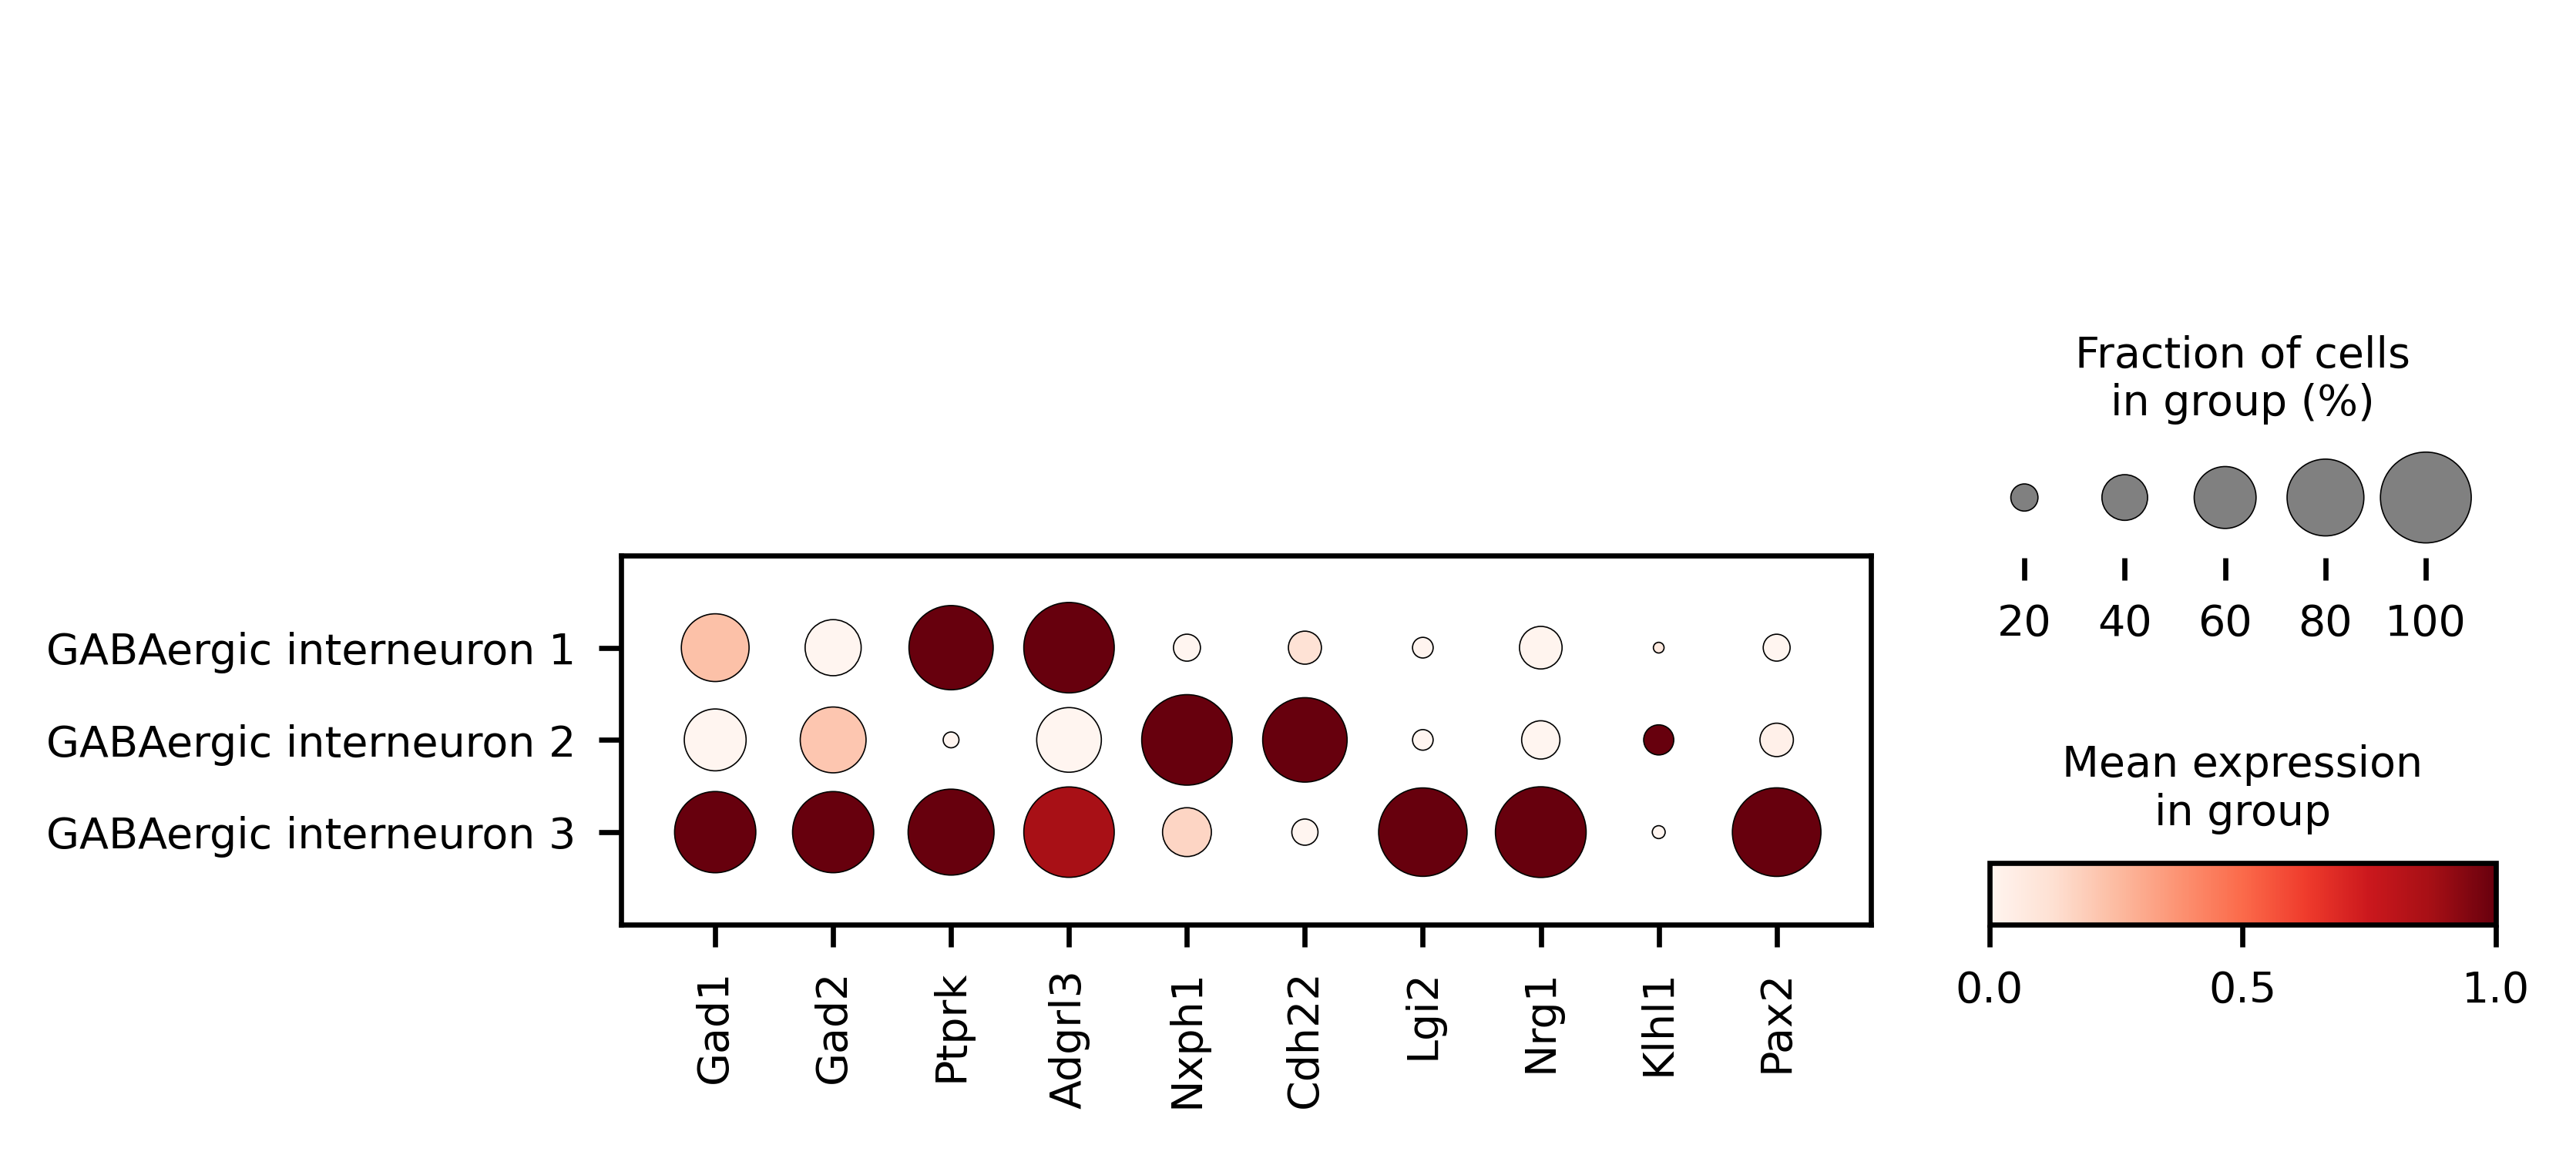

In [17]:
sc.pl.dotplot(cdata, markers2, groupby=['sub2'], standard_scale='var', save = 'GABAergic_interneurons_dotplot_v3.pdf')

In [34]:
sc.tl.louvain(bdata, restrict_to=('ctype', ['Purkinje cell']), resolution=1.5, key_added='sub1')

running Louvain clustering
    using the "louvain" package of Traag (2017)


Trying to set attribute `.obs` of view, copying.


    finished (0:00:00)


In [73]:
print(adata.obs['genotype'].value_counts())

WT      164722
SCA1    153590
Name: genotype, dtype: int64


In [15]:
adata.obs['sub2'] = pd.Series(['Astrocyte','Bergmann glia','Endothelial cell','Granule cell','GABAergic interneuron 1','GABAergic interneuron 2','GABAergic interneuron 3','Oligodendrocyte','Oligodendrocyte progenitor cell','Unipolar brush cell','Purkinje cell','Pericyte','Microglia','ZPC'], dtype = "category")
adata.obs['sub2'].cat.set_categories(['Astrocyte','Bergmann glia','Endothelial cell','Granule cell','GABAergic interneuron 1','GABAergic interneuron 2','GABAergic interneuron 3','Oligodendrocyte','Oligodendrocyte progenitor cell','Unipolar brush cell','Purkinje cell','Pericyte','Microglia','ZPC'], ordered=True, inplace=True)

In [16]:
#assign
obs = 'sub1'

ast = (adata.obs[obs]=="Astrocyte")
bg = (adata.obs[obs]=="Bergmann glia")
end = (adata.obs[obs]=="Endothelial cell")
gc = (adata.obs[obs]=="Granule cell")
gi1 = (adata.obs[obs]=="GABAergic interneuron 1")
gi2 = (adata.obs[obs]=="GABAergic interneuron 2")
gi3 = (adata.obs[obs]=="GABAergic interneuron 3")
ol = (adata.obs[obs]=="Oligodendrocyte")
opc = (adata.obs[obs]=="Oligodendrocyte progenitor cell")
ubc = (adata.obs[obs]=="Unipolar brush cell")
zpc = ((adata.obs[obs]=="Purkinje cell,0")| (adata.obs[obs]=="Purkinje cell,1")| (adata.obs[obs]=="Purkinje cell,2")
      | (adata.obs[obs]=="Purkinje cell,7"))
pc = ((adata.obs[obs]=="Purkinje cell,3")| (adata.obs[obs]=="Purkinje cell,4")| (adata.obs[obs]=="Purkinje cell,5")
      | (adata.obs[obs]=="Purkinje cell,6"))
per = (adata.obs[obs]=="Pericyte")
mg = (adata.obs[obs]=="Microglia")



new_obs = 'sub2'
adata.obs[new_obs].loc[ast] = "Astrocyte"
adata.obs[new_obs].loc[bg] = "Bergmann glia"
adata.obs[new_obs].loc[end] = "Endothelial cell"
adata.obs[new_obs].loc[gc] = "Granule cell"
adata.obs[new_obs].loc[gi1] = "GABAergic interneuron 1"
adata.obs[new_obs].loc[gi2] = "GABAergic interneuron 2"
adata.obs[new_obs].loc[gi3] = "GABAergic interneuron 3"
adata.obs[new_obs].loc[ol] = "Oligodendrocyte"
adata.obs[new_obs].loc[opc] = "Oligodendrocyte progenitor cell"
adata.obs[new_obs].loc[ubc] = "Unipolar brush cell"
adata.obs[new_obs].loc[zpc] = "ZPC"
adata.obs[new_obs].loc[pc] = "Purkinje cell"
adata.obs[new_obs].loc[per] = "Pericyte"
adata.obs[new_obs].loc[mg] = "Microglia"


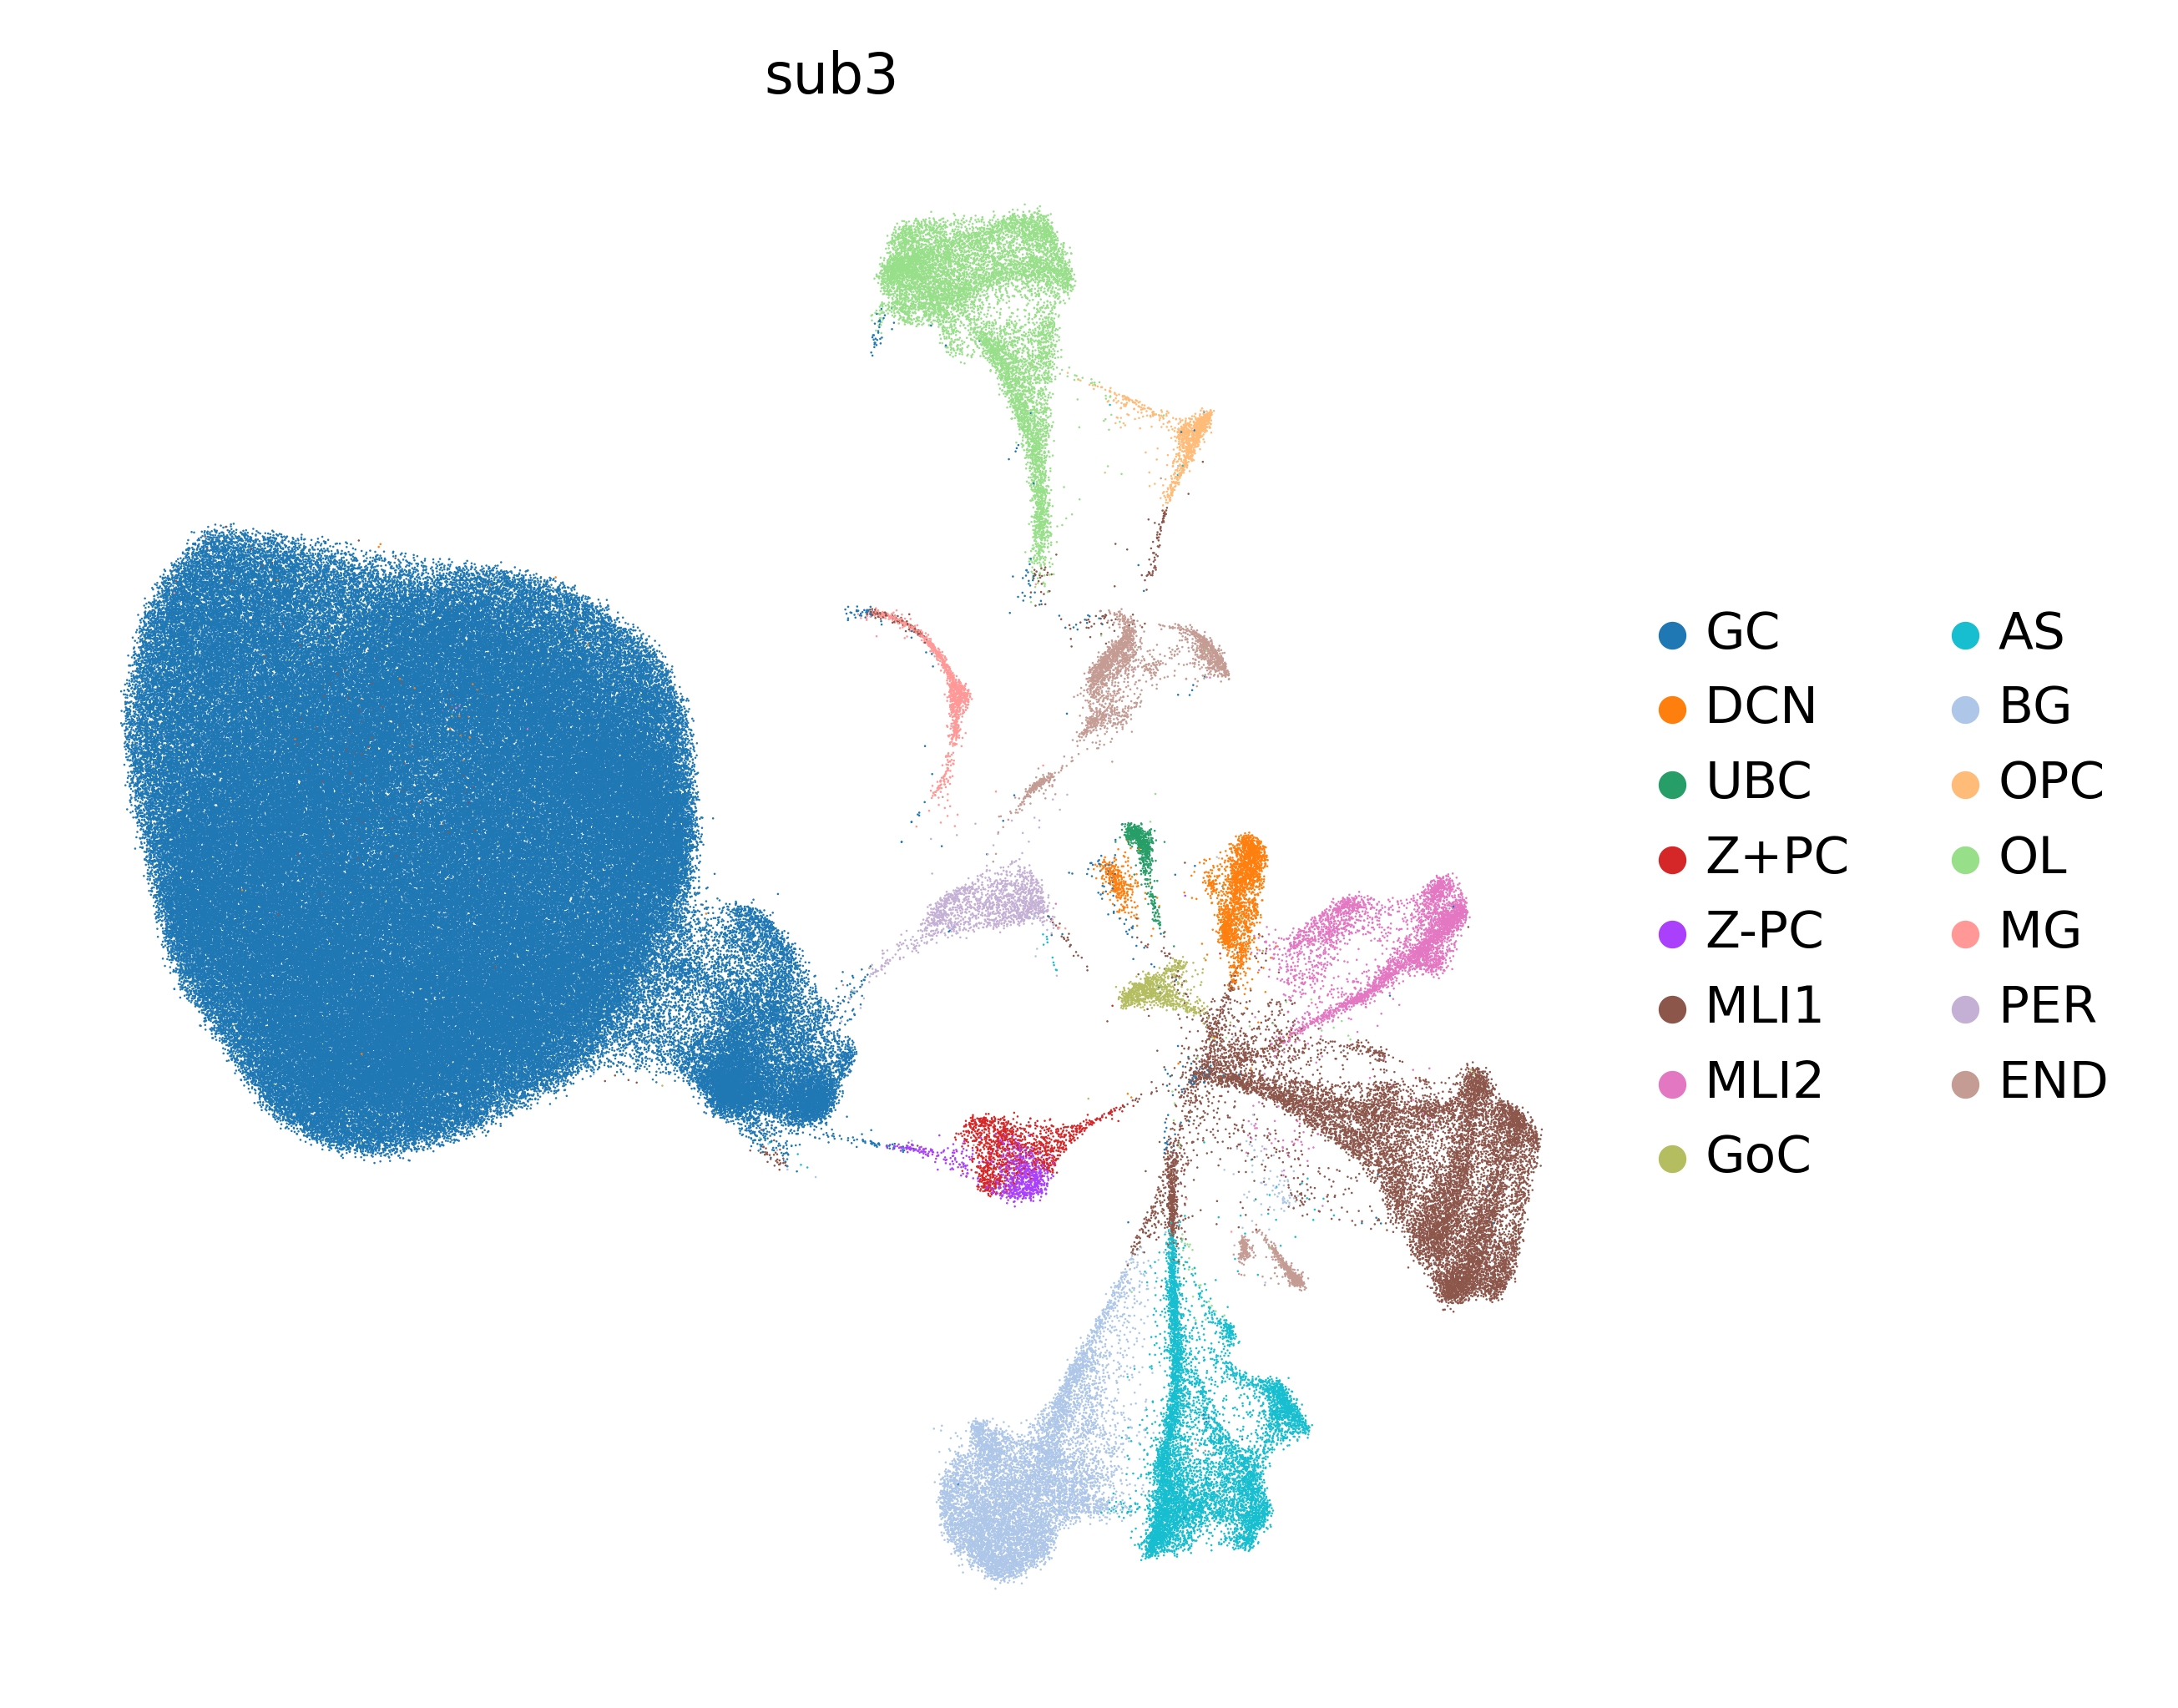

In [42]:
sc.pl.umap(adata, color = 'sub3')

In [43]:
if True :
# save adata obj with batch correction & imputation

    adata.write(os.path.join(pfp,'211027_mouse.h5ad'))
    print('\n... saved @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))


... saved @211027.12:04:41


In [ ]:
# Load Data

if True :
    start = time.time()
    backed=None # None if not
    fname='211026_mouse_imp.h5ad' # for full, can maybe get away with ~300G
    %memit adata = sc.read_h5ad(os.path.join(dfp,fname),backed=backed)
    print('loaded @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to load data'.format(time.time()-start))
    

In [74]:
#Imputation

wt = adata[adata.obs['genotype']=='WT', :]
mut = adata[adata.obs['genotype']=='SCA1', :]

In [ ]:
#k=45, t=3
print('Starting imputation for {}\n'.format('WT'))
tic = time.time()

wt = adata[adata.obs['genotype']=='WT', :]
wt.obs['value'] = 0
sc.pp.pca(wt)
sc.pp.neighbors(wt, n_pcs=45)


# MAGIC
G = gt.Graph(data=wt.obsp['connectivities']+sparse.diags([1]*wt.shape[0],format='csr'),
             precomputed='adjacency',
             use_pygsp=True)
G.knn_max = None

# MAGIC
magic_op=magic.MAGIC().fit(X=wt.X,graph=G) # running fit_transform produces wrong shape
wt.layers['imputed']=magic_op.transform(wt.X,genes='all_genes')

print('\n  imputation in {:.2f}-min'.format((time.time() - tic)/60))

print('\n Starting imputation for {}\n'.format('SCA1'))
tic = time.time()

mut = adata[adata.obs['genotype']=='SCA1', :]
mut.obs['value'] = 0
sc.pp.pca(mut)
sc.pp.neighbors(mut, n_pcs=45)

# MAGIC
G = gt.Graph(data=mut.obsp['connectivities']+sparse.diags([1]*mut.shape[0],format='csr'),
             precomputed='adjacency',
             use_pygsp=True)
G.knn_max = None

# MAGIC
magic_op=magic.MAGIC().fit(X=mut.X,graph=G) # running fit_transform produces wrong shape
mut.layers['imputed']=magic_op.transform(mut.X,genes='all_genes')

print('\n  imputation in {:.2f}-min'.format((time.time() - tic)/60))

Starting imputation for WT



In [9]:
# save data objects
wt.write(os.path.join(pdfp,'211026_WT_imp.h5ad'))
mut.write(os.path.join(pdfp,'211026_SCA1_imp.h5ad'))
print('saved @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))

In [9]:
adata.obs['sub3'] = pd.Series(['GC', 'DCN', 'UBC', 'Z+PC', 'Z-PC', 'MLI1', 'MLI2', 'GoC', 'AS', 'BG', 'OPC', 'OL', 'MG', 'PER', 'END'], dtype = "category")
adata.obs['sub3'].cat.set_categories(['GC', 'DCN', 'UBC', 'Z+PC', 'Z-PC', 'MLI1', 'MLI2', 'GoC', 'AS', 'BG', 'OPC', 'OL', 'MG', 'PER', 'END'], ordered=True, inplace=True)

In [10]:
#Assign DCN and UBC

fname = os.path.join(pfp, '/home/cl2292/project/SCA1_snRNAseq/Mouse/results/adata.obs_210726.csv')
ctype1 = 'Unipolar brush cell'
ctype2 = 'Deep cerebellar nuclei'
#load
ann=pd.read_csv(fname)
ubcdt=ann.loc[(ann['ctype_ubcupdate']==ctype1),:]
dcndt=ann.loc[(ann['ctype_ubcupdate']==ctype2),:]


In [11]:
#assign
obs = 'sub2'

gc = ((adata.obs[obs]=="Granule cell"))
zppc = ((adata.obs[obs]=="ZPC"))
znpc = ((adata.obs[obs]=="Purkinje cell"))
mli1 = (adata.obs[obs]=="GABAergic interneuron 1")
mli2 = (adata.obs[obs]=="GABAergic interneuron 2")
goc = (adata.obs[obs]=="GABAergic interneuron 3")
ast = ((adata.obs[obs]=="Astrocyte"))
bg = ((adata.obs[obs]=="Bergmann glia"))
ol = ((adata.obs[obs]=="Oligodendrocyte"))
opc = ((adata.obs[obs]=="Oligodendrocyte progenitor cell"))
mg = ((adata.obs[obs]=="Microglia"))
end =  ((adata.obs[obs]=="Endothelial cell"))
per = ((adata.obs[obs]=="Pericyte"))





new_obs = 'sub3'
adata.obs[new_obs].loc[gc] = "GC"
adata.obs[new_obs].loc[zppc] = "Z+PC"
adata.obs[new_obs].loc[znpc] = "Z-PC"
adata.obs[new_obs].loc[mli1] = "MLI1"
adata.obs[new_obs].loc[mli2] = "MLI2"
adata.obs[new_obs].loc[goc] = "GoC"
adata.obs[new_obs].loc[ast] = "AS"
adata.obs[new_obs].loc[bg] = "BG"
adata.obs[new_obs].loc[ol] = "OL"
adata.obs[new_obs].loc[opc] = "OPC"
adata.obs[new_obs].loc[mg] = "MG"
adata.obs[new_obs].loc[end] = "END"
adata.obs[new_obs].loc[per] = "PER"


for i in ubcdt['Column1']:
    ubc = (adata.obs_names == i)
    adata.obs[new_obs].loc[ubc] = "UBC"

for i in dcndt['Column1']:
    dcn = (adata.obs_names == i)
    adata.obs['sub3'].loc[dcn] = "DCN"

In [12]:
if True :
# save adata obj with batch correction & imputation

    adata.write(os.path.join(dfp,'211027_mouse_imp.h5ad'))
    print('\n... saved @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))


... saved @211027.12:10:14


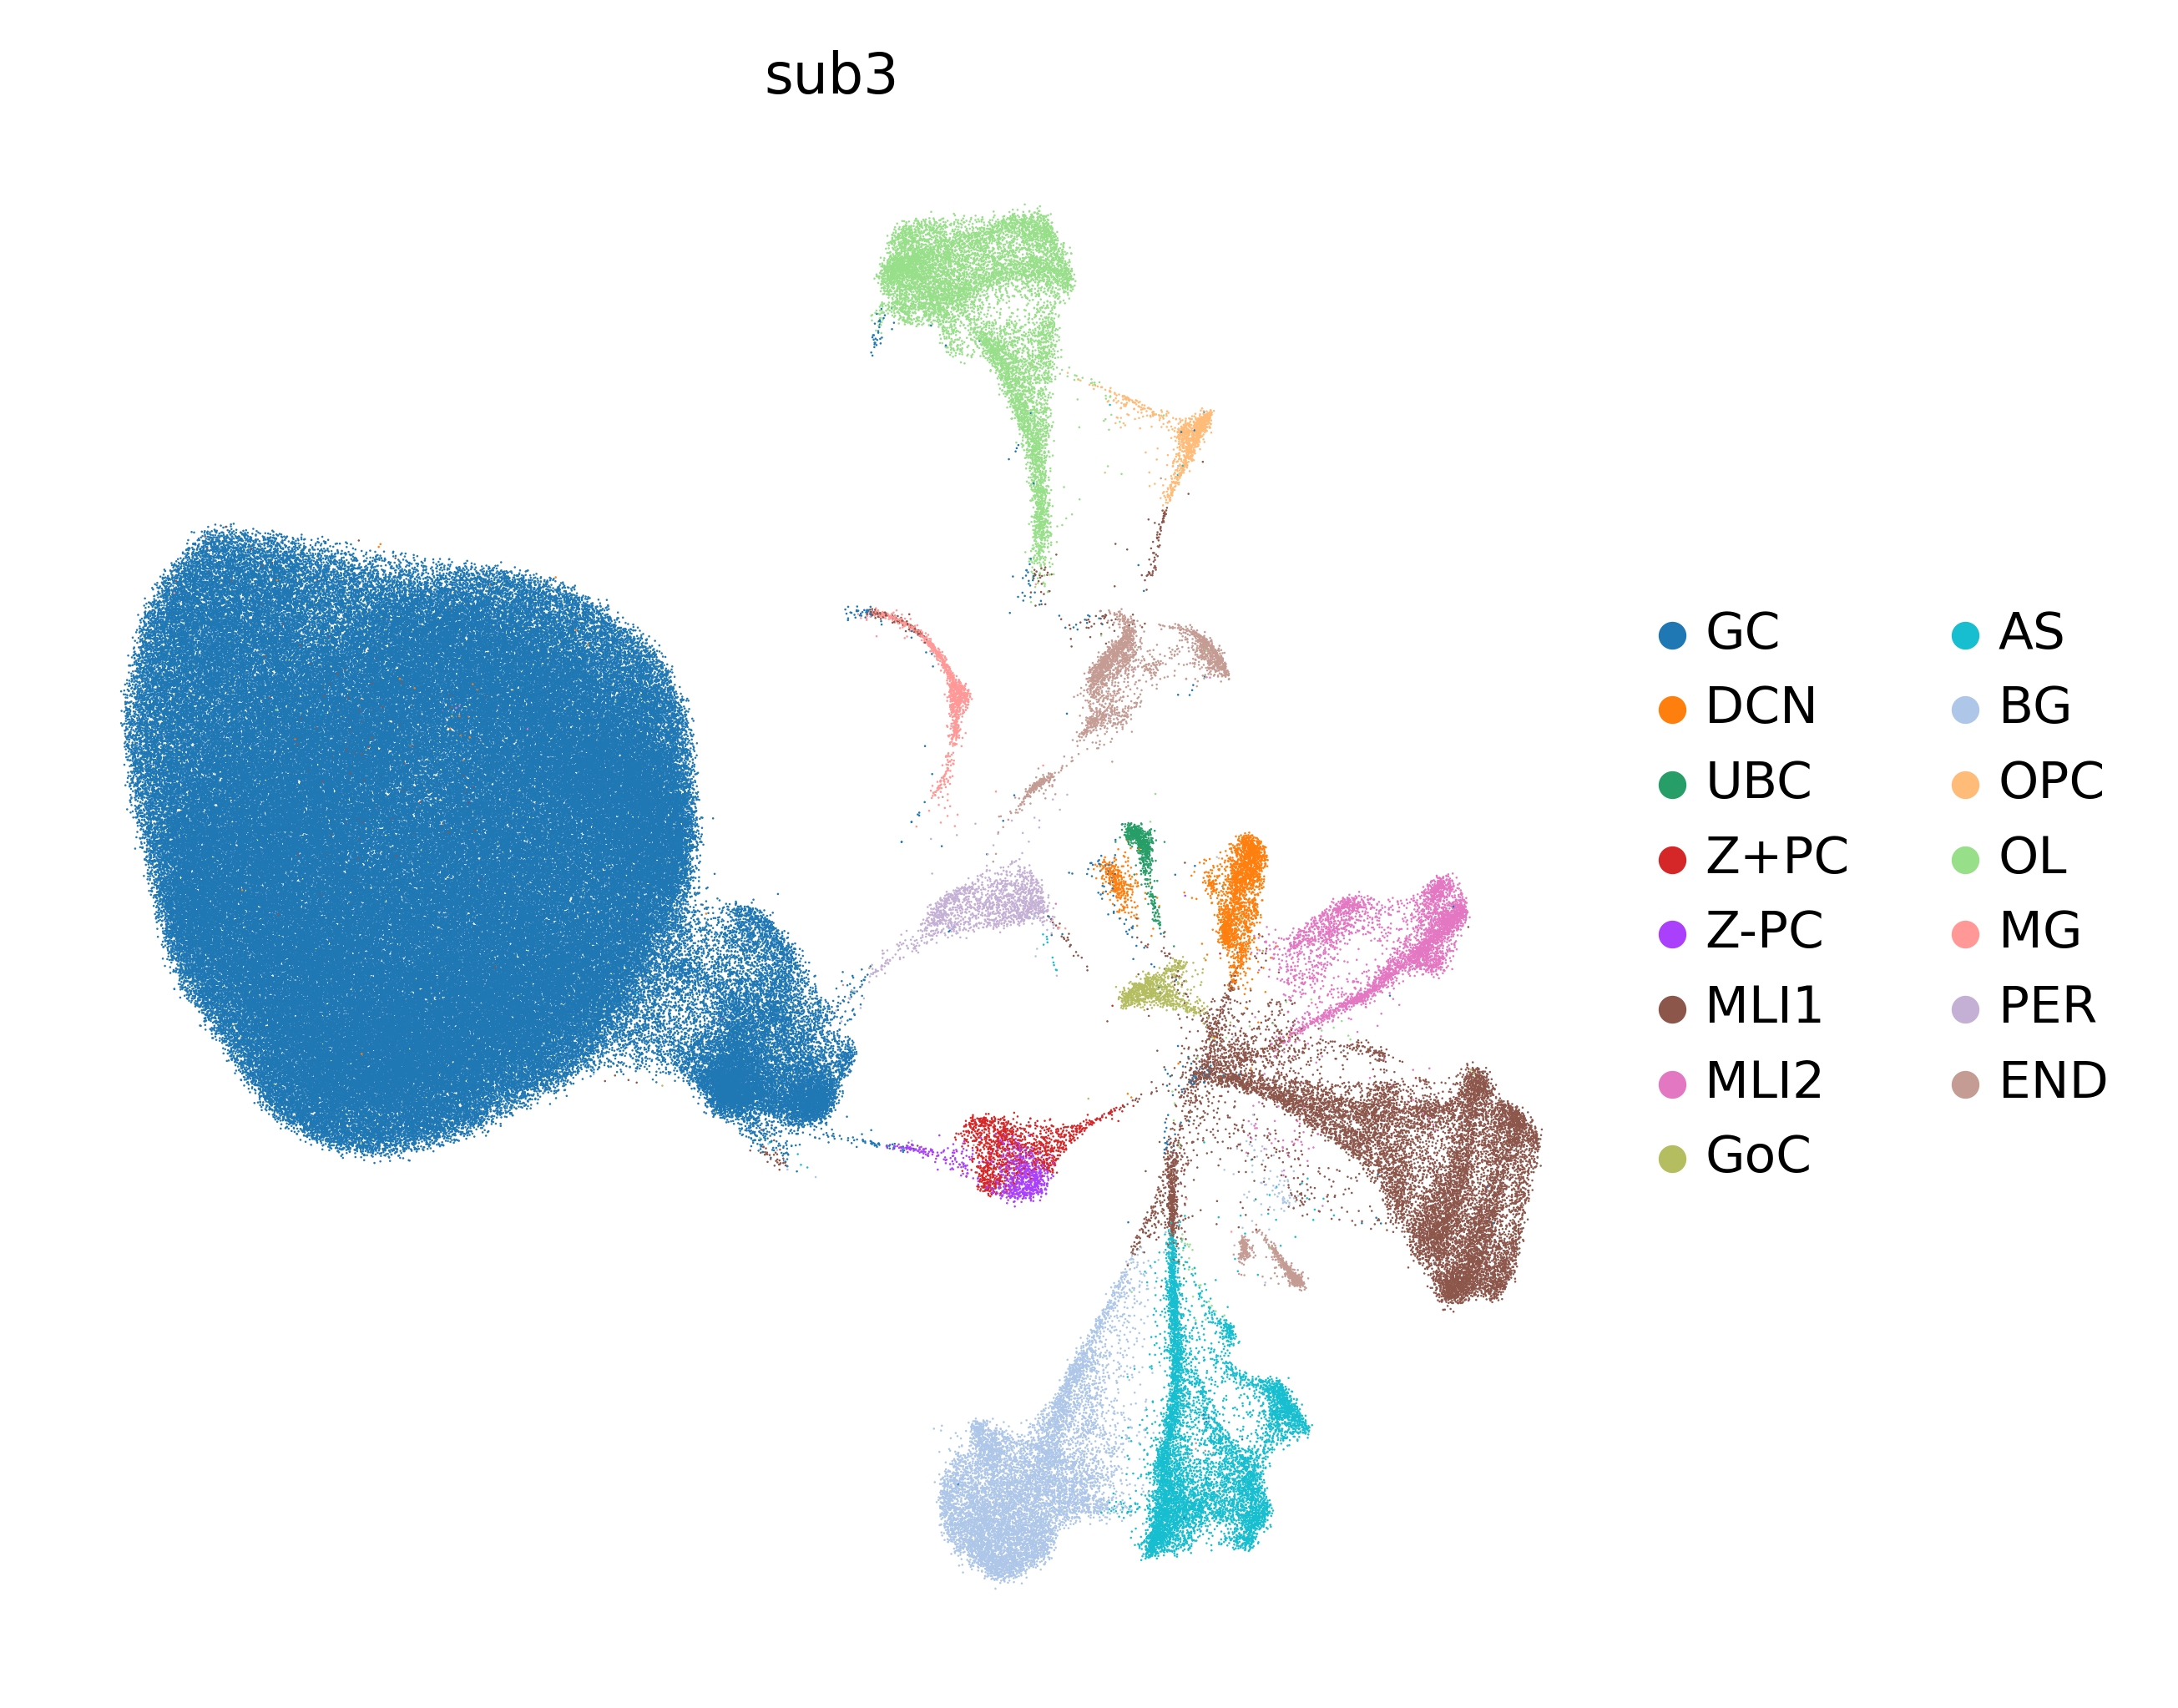

In [13]:
sc.pl.umap(adata, color = 'sub3')

In [41]:
adata.obs['sub3'].value_counts()

GC      260746
MLI1     13709
BG        9595
OL        9375
AS        8198
MLI2      3899
END       3033
DCN       2513
PER       1502
Z+PC      1334
MG        1028
OPC       1007
GoC        892
Z-PC       840
UBC        641
Name: sub3, dtype: int64

In [16]:
##Original - use for UMAP

cmap_sub3={'GC': '#FAC18A',
            'DCN': '#AAABAB',
            'UBC': '#BA61BA',
            'Z-PC': '#EE5264',
            'Z+PC': '#82c0e7',
            'MLI1': '#F9EBAE',
            'MLI2': '#88BB92',
            'GoC': '#46A928',
            'AS': '#F9AEAE',
            'BG': '#AEB7F9',
            'OPC': '#F1815F',
            'OL': '#75A3B7',
            'MG': '#AC5861',
            'PER': '#2D284B',
            'END': '#1C67EE'}

adata.uns['sub3_colors']=np.array(list(cmap_sub3.values()),dtype=object)
adata.obs['sub3'].cat.reorder_categories(new_categories=list(cmap_sub3.keys()),
                                         inplace=True,ordered=True)

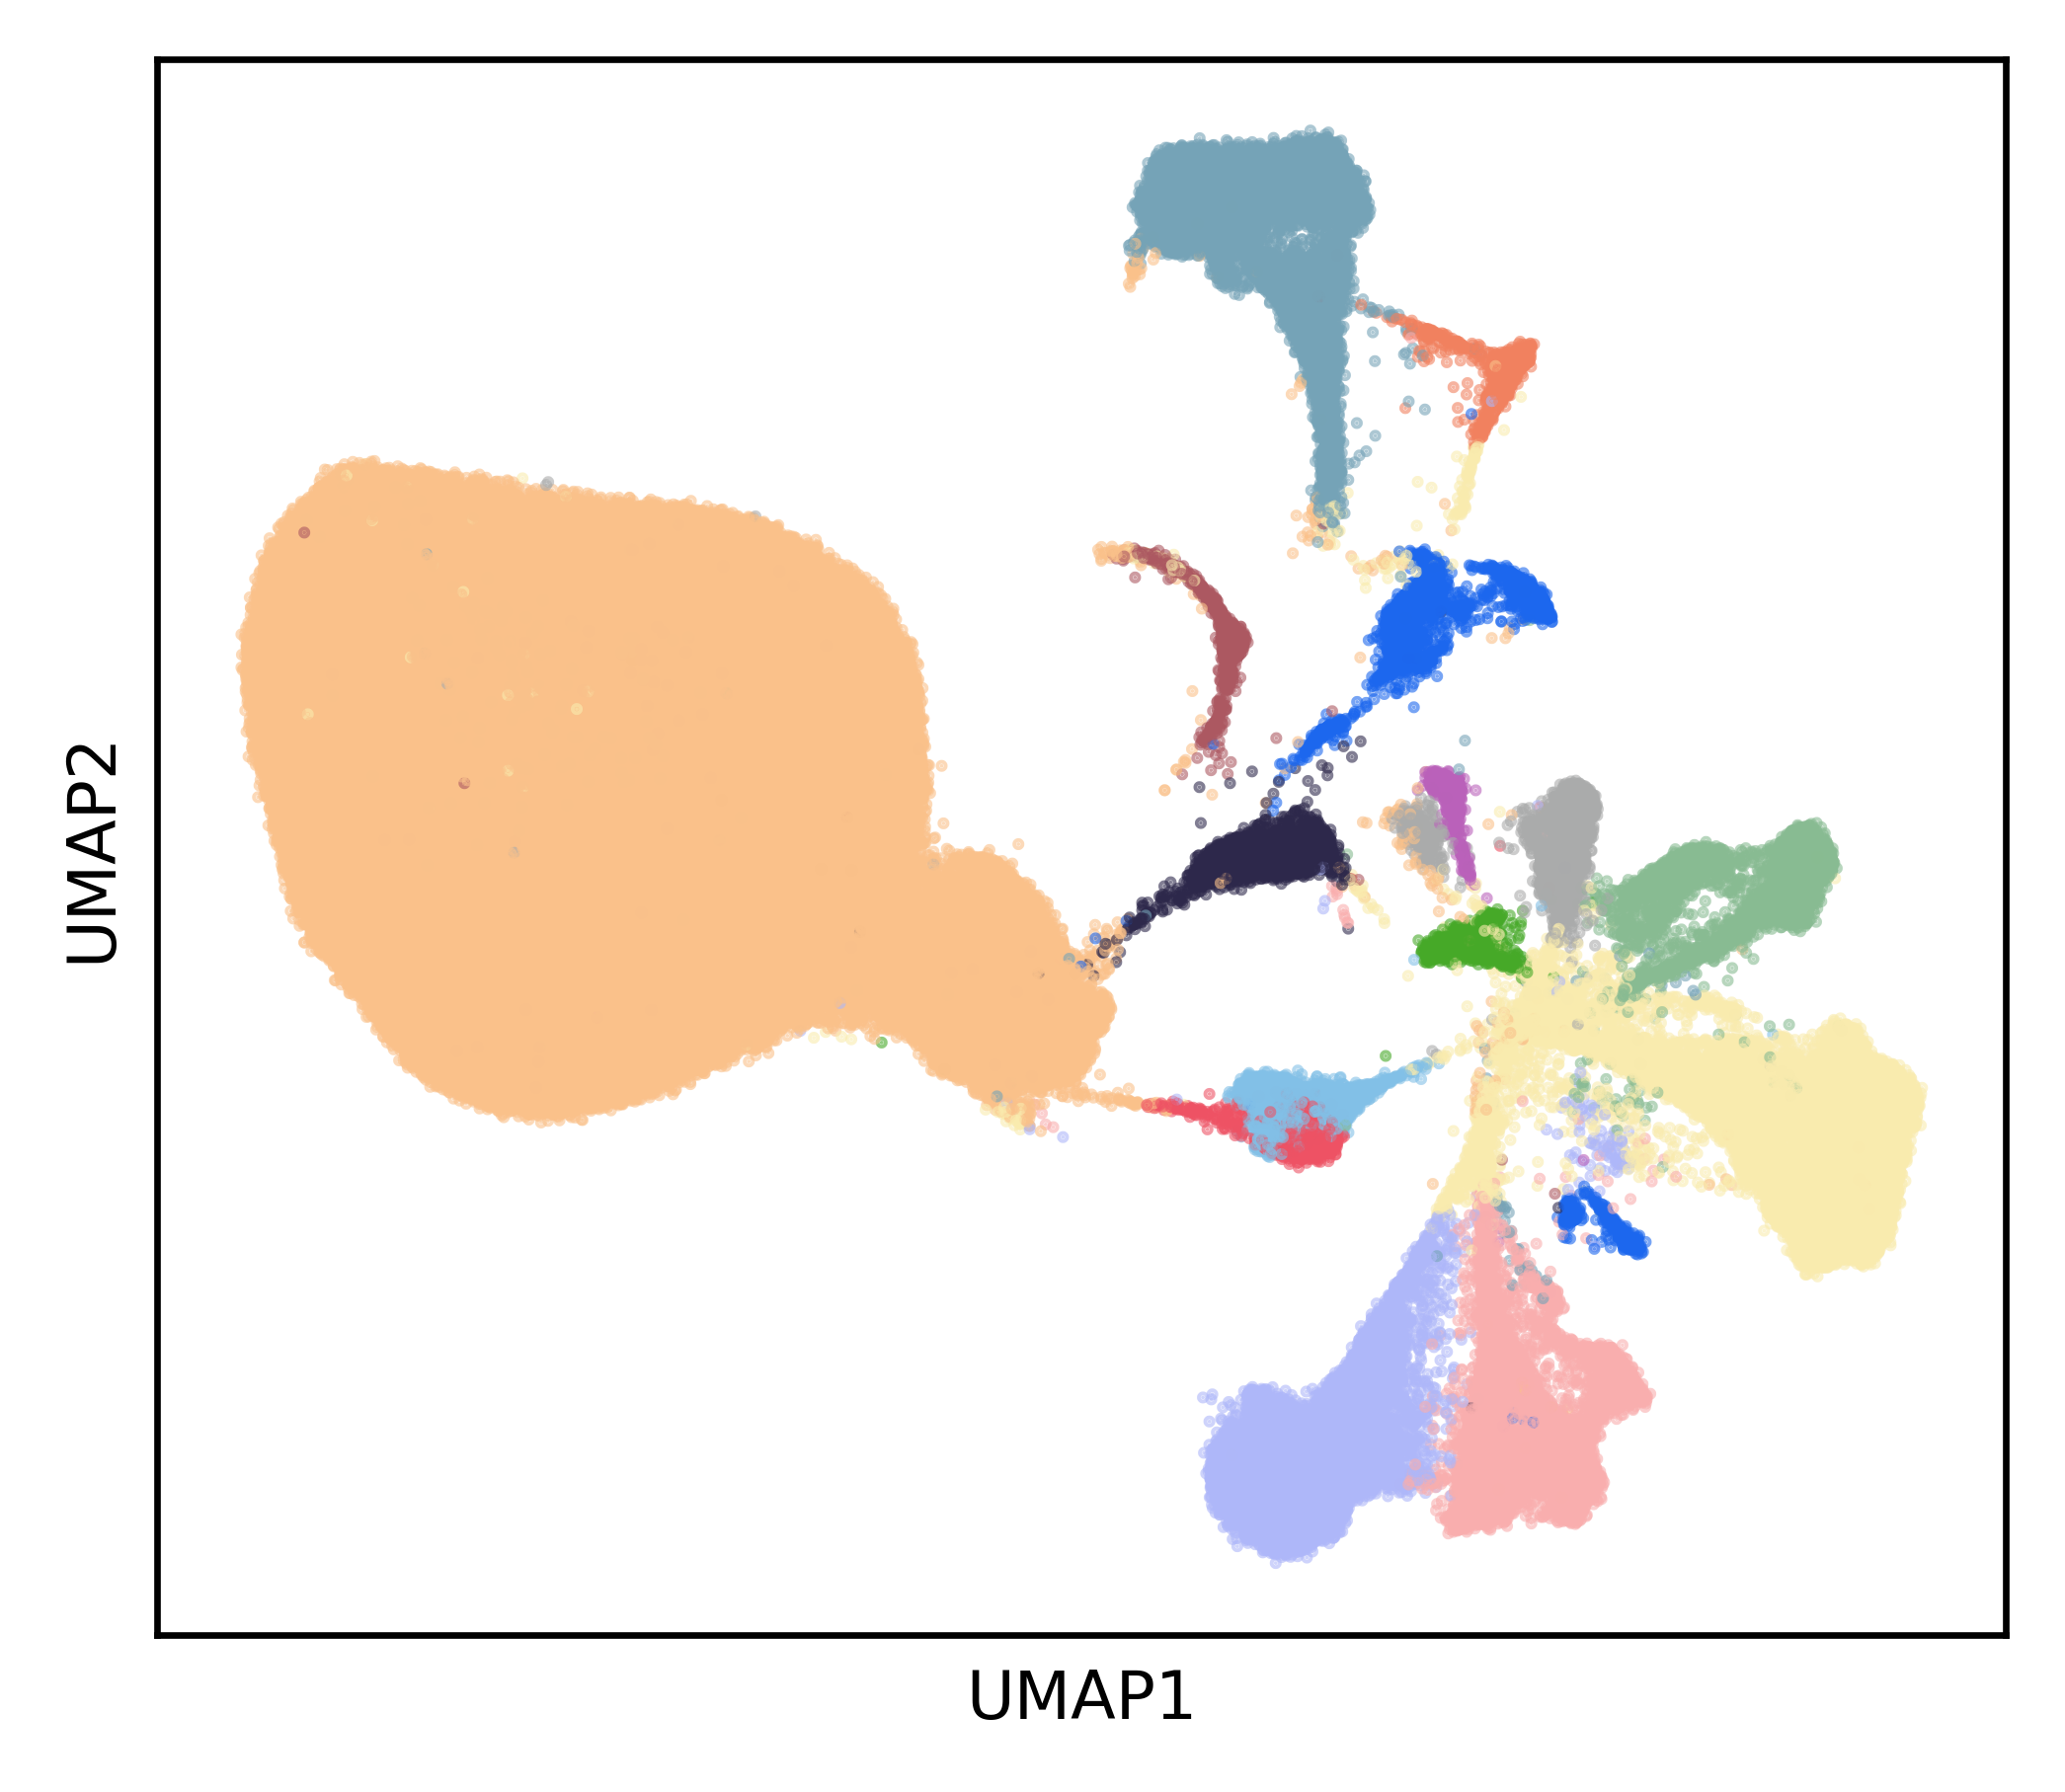

In [17]:
fig,ax=plt.subplots(1,1,figsize=(4,3.5))
scprep.plot.scatter2d(adata.obsm['X_umap'],
                      c=adata.obs['sub3'],
                      cmap=cmap_sub3,
                      ticks=None,
                      label_prefix='UMAP',
                      legend=False,
                      ax=ax,
                      s = 0.2,
                      alpha=0.6,
                      rasterized=True)
if True :
    fig.savefig(os.path.join(pfp,'embeds_mouse_updated_ctype.pdf'),dpi=600,bbox_inches='tight')